In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers
from tensorflow.keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfp.__version__

'0.8.0'

In [2]:
def bnn_extractor(flat_observations, net_arch, act_fun):
    """
    Constructs an variational layer that receives observations as an input and outputs a latent representation for the policy and
    a value network. The ``net_arch`` parameter allows to specify the amount and size of the hidden layers and how many
    of them are shared between the policy network and the value network. It is assumed to be a list with the following
    structure:
    1. An arbitrary length (zero allowed) number of integers each specifying the number of units in a shared layer.
       If the number of ints is zero, there will be no shared layers.
    2. An optional dict, to specify the following non-shared layers for the value network and the policy network.
       It is formatted like ``dict(vf=[<value layer sizes>], pi=[<policy layer sizes>])``.
       If it is missing any of the keys (pi or vf), no non-shared layers (empty list) is assumed.
    For example to construct a network with one shared layer of size 55 followed by two non-shared layers for the value
    network of size 255 and a single non-shared layer of size 128 for the policy network, the following layers_spec
    would be used: ``[55, dict(vf=[255, 255], pi=[128])]``. A simple shared network topology with two layers of size 128
    would be specified as [128, 128].
    :param flat_observations: (tf.Tensor) The observations to base policy and value function on.
    :param net_arch: ([int or dict]) The specification of the policy and value networks.
        See above for details on its formatting.
    :param act_fun: (tf function) The activation function to use for the networks.
    :return: (tf.Tensor, tf.Tensor) latent_policy, latent_value of the specified network.
        If all layers are shared, then ``latent_policy == latent_value``
    """
    latent = flat_observations
    policy_only_layers = []  # Layer sizes of the network that only belongs to the policy network
    value_only_layers = []  # Layer sizes of the network that only belongs to the value network
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p)

    # Iterate through the shared layers and build the shared parts of the network
    for idx, layer in enumerate(net_arch):
        if isinstance(layer, int):  # Check that this is a shared layer
            layer_size = layer
#             latent = act_fun(linear(latent, "shared_fc{}".format(idx), layer_size, init_scale=np.sqrt(2)))
            latent = act_fun(tfp.layers.DenseFlipout(layer_size, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn)(latent))
        else:
            assert isinstance(layer, dict), "Error: the net_arch list can only contain ints and dicts"
            if 'pi' in layer:
                assert isinstance(layer['pi'], list), "Error: net_arch[-1]['pi'] must contain a list of integers."
                policy_only_layers = layer['pi']

            if 'vf' in layer:
                assert isinstance(layer['vf'], list), "Error: net_arch[-1]['vf'] must contain a list of integers."
                value_only_layers = layer['vf']
            break  # From here on the network splits up in policy and value network

    # Build the non-shared part of the network
    latent_policy = latent
    latent_value = latent
    for idx, (pi_layer_size, vf_layer_size) in enumerate(zip_longest(policy_only_layers, value_only_layers)):
        if pi_layer_size is not None:
            assert isinstance(pi_layer_size, int), "Error: net_arch[-1]['pi'] must only contain integers."
#             latent_policy = act_fun(linear(latent_policy, "pi_fc{}".format(idx), pi_layer_size, init_scale=np.sqrt(2)))
            latent_policy = act_fun(tfp.layers.DenseFlipout(pi_layer_size, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn)(latent))

        if vf_layer_size is not None:
            assert isinstance(vf_layer_size, int), "Error: net_arch[-1]['vf'] must only contain integers."
#             latent_value = act_fun(linear(latent_value, "vf_fc{}".format(idx), vf_layer_size, init_scale=np.sqrt(2)))
            latent_value = act_fun(tfp.layers.DenseFlipout(vf_layer_size, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn)(latent))

    return latent_policy, latent_value

In [3]:
from stable_baselines.common.policies import ActorCriticPolicy, nature_cnn

class FeedForwardPolicy(ActorCriticPolicy):
    """
    Policy object that implements actor critic, using a feed forward neural network.
    :param sess: (TensorFlow session) The current TensorFlow session
    :param ob_space: (Gym Space) The observation space of the environment
    :param ac_space: (Gym Space) The action space of the environment
    :param n_env: (int) The number of environments to run
    :param n_steps: (int) The number of steps to run for each environment
    :param n_batch: (int) The number of batch to run (n_envs * n_steps)
    :param reuse: (bool) If the policy is reusable or not
    :param layers: ([int]) (deprecated, use net_arch instead) The size of the Neural network for the policy
        (if None, default to [64, 64])
    :param net_arch: (list) Specification of the actor-critic policy network architecture (see mlp_extractor
        documentation for details).
    :param act_fun: (tf.func) the activation function to use in the neural network.
    :param cnn_extractor: (function (TensorFlow Tensor, ``**kwargs``): (TensorFlow Tensor)) the CNN feature extraction
    :param feature_extraction: (str) The feature extraction type ("cnn" or "mlp")
    :param kwargs: (dict) Extra keyword arguments for the nature CNN feature extraction
    """

    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, layers=None, net_arch=None,
                 act_fun=tf.tanh, cnn_extractor=nature_cnn, feature_extraction="cnn", **kwargs):
        super(FeedForwardPolicy, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=reuse,
                                                scale=(feature_extraction == "cnn"))

        self._kwargs_check(feature_extraction, kwargs)

        if layers is not None:
            warnings.warn("Usage of the `layers` parameter is deprecated! Use net_arch instead "
                          "(it has a different semantics though).", DeprecationWarning)
            if net_arch is not None:
                warnings.warn("The new `net_arch` parameter overrides the deprecated `layers` parameter!",
                              DeprecationWarning)

        if net_arch is None:
            if layers is None:
                layers = [64, 64]
            net_arch = [dict(vf=layers, pi=layers)]

        with tf.variable_scope("model", reuse=reuse):
            if feature_extraction == "cnn":
                pi_latent = vf_latent = cnn_extractor(self.processed_obs, **kwargs)
            elif feature_extraction == "bnn":
                pi_latent, vf_latent = bnn_extractor(tf.layers.flatten(self.processed_obs), net_arch, act_fun)
            else:
                pi_latent, vf_latent = mlp_extractor(tf.layers.flatten(self.processed_obs), net_arch, act_fun)

            self._value_fn = linear(vf_latent, 'vf', 1)

            self._proba_distribution, self._policy, self.q_value = \
                self.pdtype.proba_distribution_from_latent(pi_latent, vf_latent, init_scale=0.01)

        self._setup_init()

    def step(self, obs, state=None, mask=None, deterministic=False):
        if deterministic:
            action, value, neglogp = self.sess.run([self.deterministic_action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        else:
            action, value, neglogp = self.sess.run([self.action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        return action, value, self.initial_state, neglogp

    def proba_step(self, obs, state=None, mask=None):
        return self.sess.run(self.policy_proba, {self.obs_ph: obs})

    def value(self, obs, state=None, mask=None):
        return self.sess.run(self.value_flat, {self.obs_ph: obs})

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
import warnings
from itertools import zip_longest
from abc import ABC, abstractmethod

import numpy as np
import tensorflow as tf
from gym.spaces import Discrete

from stable_baselines.common.tf_util import batch_to_seq, seq_to_batch
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
from stable_baselines.common.distributions import make_proba_dist_type, CategoricalProbabilityDistribution, \
    MultiCategoricalProbabilityDistribution, DiagGaussianProbabilityDistribution, BernoulliProbabilityDistribution
from stable_baselines.common.input import observation_input
from stable_baselines.common.policies import nature_cnn

In [5]:
class BnnPolicy(FeedForwardPolicy):
    """
    Policy object that implements actor critic, using a Bayesian neural net (2 layers of 64)
    :param sess: (TensorFlow session) The current TensorFlow session
    :param ob_space: (Gym Space) The observation space of the environment
    :param ac_space: (Gym Space) The action space of the environment
    :param n_env: (int) The number of environments to run
    :param n_steps: (int) The number of steps to run for each environment
    :param n_batch: (int) The number of batch to run (n_envs * n_steps)
    :param reuse: (bool) If the policy is reusable or not
    :param _kwargs: (dict) Extra keyword arguments for the nature CNN feature extraction
    """

    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, **_kwargs):
        super(BnnPolicy, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse,
                                        feature_extraction="bnn", **_kwargs)

# DNN Acrobot

In [6]:
import os
import gym

from stable_baselines.ppo1 import PPO1
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import logger
from stable_baselines.common.callbacks import EvalCallback

In [7]:
NUM_TIMESTEPS = int(1e6)
SEED = 722
EVAL_FREQ = 500
EVAL_EPISODES = 10  # was 1000

In [8]:
LOGDIR = "acrobot" # moved to zoo afterwards.
logger.configure(folder=LOGDIR)

env = gym.make("Acrobot-v1")
env.seed(SEED)

Logging to acrobot


[722]

In [ ]:
# take mujoco hyperparams (but doubled timesteps_per_actorbatch to cover more steps.)
dnn = PPO1(MlpPolicy, env, timesteps_per_actorbatch=4096, clip_param=0.2, entcoeff=0.0, optim_epochs=10,
                 optim_stepsize=3e-4, optim_batchsize=64, gamma=0.99, lam=0.95, schedule='linear', verbose=2)

In [52]:
eval_callback = EvalCallback(env, best_model_save_path=LOGDIR, log_path=LOGDIR, eval_freq=EVAL_FREQ, n_eval_episodes=EVAL_EPISODES)

dnn.learn(total_timesteps=NUM_TIMESTEPS, callback=eval_callback)

dnn.save(os.path.join(LOGDIR, "final_model")) # probably never get to this point.

env.close()

********** Iteration 0 ************


/Users/stephen/anaconda3/envs/slime-rl/lib/python3.7/site-packages/stable_baselines/common/callbacks.py:287: UserWarning: Training and eval env are not of the same type<TimeLimit<AcrobotEnv<Acrobot-v1>>> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fbf0c6dce50>
  "{} != {}".format(self.training_env, self.eval_env))


Eval num_timesteps=0, episode_reward=-417.40 +/- 94.19
Episode length: 417.90 +/- 93.75
New best mean reward!
Eval num_timesteps=0, episode_reward=-406.00 +/- 116.83
Episode length: 406.40 +/- 116.35
New best mean reward!
Eval num_timesteps=0, episode_reward=-423.50 +/- 110.73
Episode length: 423.90 +/- 110.31
Eval num_timesteps=0, episode_reward=-365.40 +/- 88.89
Episode length: 366.20 +/- 88.59
New best mean reward!
Eval num_timesteps=0, episode_reward=-425.00 +/- 82.47
Episode length: 425.50 +/- 82.01
Eval num_timesteps=0, episode_reward=-429.90 +/- 85.21
Episode length: 430.40 +/- 84.80
Eval num_timesteps=0, episode_reward=-391.00 +/- 93.20
Episode length: 391.70 +/- 92.85
Eval num_timesteps=0, episode_reward=-423.20 +/- 96.66
Episode length: 423.70 +/- 96.26
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00026 |       0.00000 |     239.78580 |       0.00069 |       1.09795
     -0.00110 |       0.00000 |     178.64015 |       0.

     -0.00173 |       0.00000 |      34.88096 |       0.00315 |       1.07641
Evaluating losses...
     -0.00296 |       0.00000 |      34.67294 |       0.00429 |       1.07431
-----------------------------------
| EpLenMean       | 500           |
| EpRewMean       | -500          |
| EpThisIter      | 8             |
| EpisodesSoFar   | 32            |
| TimeElapsed     | 96.1          |
| TimestepsSoFar  | 16384         |
| ev_tdlam_before | -0.00366      |
| loss_ent        | 1.074305      |
| loss_kl         | 0.004289391   |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0029649534 |
| loss_vf_loss    | 34.672935     |
-----------------------------------
********** Iteration 4 ************
Eval num_timesteps=16384, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=16384, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=16384, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_time

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     1.71e-05 |       0.00000 |      84.81113 |       0.00066 |       1.08288
     -0.00123 |       0.00000 |      77.75255 |       0.00201 |       1.07924
     -0.00271 |       0.00000 |      74.90385 |       0.00718 |       1.06851
     -0.00305 |       0.00000 |      73.79113 |       0.00797 |       1.06754
     -0.00329 |       0.00000 |      73.36186 |       0.00895 |       1.06657
     -0.00329 |       0.00000 |      73.20257 |       0.00888 |       1.06653
     -0.00383 |       0.00000 |      73.14801 |       0.00841 |       1.06645
     -0.00368 |       0.00000 |      73.12551 |       0.00898 |       1.06677
     -0.00383 |       0.00000 |      73.12211 |       0.00834 |       1.07017
     -0.00430 |       0.00000 |      73.12099 |       0.00994 |       1.06669
Evaluating losses...
     -0.00468 |       0.00000 |      73.11333 |       0.00704 |       1.07113
-----------------------------------
| EpLen

********** Iteration 11 ************
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=45056, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00010 |       0.00000 |     117.27459 |       0.00105 |       1.03836
     -0.00299 |       0.00000 |     102.53395 |       0.00257 |       1.0

     -0.01004 |       0.00000 |      20.48277 |       0.00783 |       0.97431
Evaluating losses...
     -0.01077 |       0.00000 |      20.09076 |       0.00649 |       0.98366
---------------------------------
| EpLenMean       | 498         |
| EpRewMean       | -498        |
| EpThisIter      | 9           |
| EpisodesSoFar   | 123         |
| TimeElapsed     | 365         |
| TimestepsSoFar  | 61440       |
| ev_tdlam_before | 0.923       |
| loss_ent        | 0.98366356  |
| loss_kl         | 0.006488354 |
| loss_pol_entpen | 0.0         |
| loss_pol_surr   | -0.01077407 |
| loss_vf_loss    | 20.090757   |
---------------------------------
********** Iteration 15 ************
Eval num_timesteps=61440, episode_reward=-289.10 +/- 119.80
Episode length: 289.90 +/- 119.45
New best mean reward!
Eval num_timesteps=61440, episode_reward=-181.70 +/- 46.06
Episode length: 182.70 +/- 46.06
New best mean reward!
Eval num_timesteps=61440, episode_reward=-233.40 +/- 66.52
Episode length: 234.4

Eval num_timesteps=73728, episode_reward=-116.80 +/- 21.06
Episode length: 117.80 +/- 21.06
Eval num_timesteps=73728, episode_reward=-123.90 +/- 40.27
Episode length: 124.90 +/- 40.27
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00376 |       0.00000 |      71.59366 |       0.00278 |       0.84910
     -0.00707 |       0.00000 |      69.63634 |       0.00776 |       0.81839
     -0.00805 |       0.00000 |      68.73539 |       0.00683 |       0.82801
     -0.00863 |       0.00000 |      68.21500 |       0.00941 |       0.81238
     -0.00870 |       0.00000 |      67.34636 |       0.00839 |       0.82055
     -0.00917 |       0.00000 |      66.71078 |       0.00707 |       0.82310
     -0.00923 |       0.00000 |      66.52464 |       0.00865 |       0.81330
     -0.00964 |       0.00000 |      65.88665 |       0.00941 |       0.81342
     -0.00982 |       0.00000 |      65.46067 |       0.00787 |       0.82089
     -0.00986 |       

********** Iteration 22 ************
Eval num_timesteps=90112, episode_reward=-86.40 +/- 12.24
Episode length: 87.40 +/- 12.24
New best mean reward!
Eval num_timesteps=90112, episode_reward=-112.90 +/- 59.36
Episode length: 113.90 +/- 59.36
Eval num_timesteps=90112, episode_reward=-147.20 +/- 128.79
Episode length: 148.10 +/- 128.52
Eval num_timesteps=90112, episode_reward=-90.60 +/- 16.64
Episode length: 91.60 +/- 16.64
Eval num_timesteps=90112, episode_reward=-109.80 +/- 44.88
Episode length: 110.80 +/- 44.88
Eval num_timesteps=90112, episode_reward=-88.00 +/- 10.85
Episode length: 89.00 +/- 10.85
Eval num_timesteps=90112, episode_reward=-89.10 +/- 23.78
Episode length: 90.10 +/- 23.78
Eval num_timesteps=90112, episode_reward=-97.70 +/- 20.92
Episode length: 98.70 +/- 20.92
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00163 |       0.00000 |      65.67307 |       0.00274 |       0.62807
     -0.00403 |       0.00000 |      58.625

     -0.00666 |       0.00000 |      62.71004 |       0.00452 |       0.52829
     -0.00700 |       0.00000 |      62.26494 |       0.00414 |       0.51903
     -0.00745 |       0.00000 |      61.77905 |       0.00526 |       0.52435
Evaluating losses...
     -0.00838 |       0.00000 |      61.32778 |       0.00450 |       0.51959
----------------------------------
| EpLenMean       | 135          |
| EpRewMean       | -134         |
| EpThisIter      | 31           |
| EpisodesSoFar   | 374          |
| TimeElapsed     | 468          |
| TimestepsSoFar  | 106496       |
| ev_tdlam_before | 0.789        |
| loss_ent        | 0.5195855    |
| loss_kl         | 0.004497221  |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.008375313 |
| loss_vf_loss    | 61.32778     |
----------------------------------
********** Iteration 26 ************
Eval num_timesteps=106496, episode_reward=-101.60 +/- 39.00
Episode length: 102.60 +/- 39.00
Eval num_timesteps=106496, episode_reward=-94.9

Eval num_timesteps=118784, episode_reward=-113.00 +/- 54.91
Episode length: 114.00 +/- 54.91
Eval num_timesteps=118784, episode_reward=-107.00 +/- 57.62
Episode length: 108.00 +/- 57.62
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00020 |       0.00000 |      49.52408 |       0.00067 |       0.42662
     -0.00169 |       0.00000 |      44.28245 |       0.00176 |       0.41617
     -0.00193 |       0.00000 |      42.48097 |       0.00188 |       0.41407
     -0.00249 |       0.00000 |      41.49489 |       0.00271 |       0.40766
     -0.00269 |       0.00000 |      40.84729 |       0.00229 |       0.41496
     -0.00346 |       0.00000 |      40.36279 |       0.00397 |       0.40566
     -0.00306 |       0.00000 |      39.93815 |       0.00255 |       0.41437
     -0.00367 |       0.00000 |      39.70503 |       0.00352 |       0.40267
     -0.00374 |       0.00000 |      39.35730 |       0.00310 |       0.40816
     -0.00417 |     

********** Iteration 33 ************
Eval num_timesteps=135168, episode_reward=-80.70 +/- 7.17
Episode length: 81.70 +/- 7.17
Eval num_timesteps=135168, episode_reward=-86.20 +/- 10.32
Episode length: 87.20 +/- 10.32
Eval num_timesteps=135168, episode_reward=-80.40 +/- 12.50
Episode length: 81.40 +/- 12.50
Eval num_timesteps=135168, episode_reward=-96.00 +/- 26.99
Episode length: 97.00 +/- 26.99
Eval num_timesteps=135168, episode_reward=-96.10 +/- 47.12
Episode length: 97.10 +/- 47.12
Eval num_timesteps=135168, episode_reward=-79.40 +/- 8.10
Episode length: 80.40 +/- 8.10
Eval num_timesteps=135168, episode_reward=-87.50 +/- 33.39
Episode length: 88.50 +/- 33.39
Eval num_timesteps=135168, episode_reward=-110.60 +/- 59.67
Episode length: 111.60 +/- 59.67
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     2.46e-05 |       0.00000 |      46.38059 |       0.00039 |       0.34297
     -0.00196 |       0.00000 |      45.32023 |       0.00117 |    

     -0.00296 |       0.00000 |      40.14505 |       0.00205 |       0.30780
     -0.00394 |       0.00000 |      40.20996 |       0.00142 |       0.31526
     -0.00379 |       0.00000 |      39.86070 |       0.00219 |       0.30921
Evaluating losses...
     -0.00492 |       0.00000 |      39.48935 |       0.00185 |       0.30734
-----------------------------------
| EpLenMean       | 98.5          |
| EpRewMean       | -97.5         |
| EpThisIter      | 42            |
| EpisodesSoFar   | 802           |
| TimeElapsed     | 545           |
| TimestepsSoFar  | 151552        |
| ev_tdlam_before | 0.841         |
| loss_ent        | 0.30733806    |
| loss_kl         | 0.0018458668  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0049177753 |
| loss_vf_loss    | 39.48935      |
-----------------------------------
********** Iteration 37 ************
Eval num_timesteps=151552, episode_reward=-82.70 +/- 14.76
Episode length: 83.70 +/- 14.76
Eval num_timesteps=151552, episode_

Eval num_timesteps=163840, episode_reward=-78.90 +/- 8.36
Episode length: 79.90 +/- 8.36
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00108 |       0.00000 |      48.87150 |       0.00110 |       0.27348
     -0.00227 |       0.00000 |      46.64653 |       0.00123 |       0.27551
     -0.00234 |       0.00000 |      46.04998 |       0.00117 |       0.27549
     -0.00252 |       0.00000 |      45.46159 |       0.00142 |       0.27624
     -0.00276 |       0.00000 |      45.18456 |       0.00125 |       0.27709
     -0.00321 |       0.00000 |      44.85375 |       0.00115 |       0.27627
     -0.00309 |       0.00000 |      44.55554 |       0.00151 |       0.27438
     -0.00322 |       0.00000 |      44.48428 |       0.00129 |       0.27817
     -0.00349 |       0.00000 |      44.38503 |       0.00101 |       0.27644
     -0.00381 |       0.00000 |      43.93021 |       0.00123 |       0.27471
Evaluating losses...
     -0.00444 |   

********** Iteration 44 ************
Eval num_timesteps=180224, episode_reward=-83.50 +/- 12.12
Episode length: 84.50 +/- 12.12
Eval num_timesteps=180224, episode_reward=-107.00 +/- 69.54
Episode length: 108.00 +/- 69.54
Eval num_timesteps=180224, episode_reward=-81.80 +/- 10.06
Episode length: 82.80 +/- 10.06
Eval num_timesteps=180224, episode_reward=-109.40 +/- 50.10
Episode length: 110.40 +/- 50.10
Eval num_timesteps=180224, episode_reward=-93.80 +/- 22.64
Episode length: 94.80 +/- 22.64
Eval num_timesteps=180224, episode_reward=-82.60 +/- 13.92
Episode length: 83.60 +/- 13.92
Eval num_timesteps=180224, episode_reward=-86.20 +/- 19.46
Episode length: 87.20 +/- 19.46
Eval num_timesteps=180224, episode_reward=-88.30 +/- 12.59
Episode length: 89.30 +/- 12.59
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00080 |       0.00000 |      47.57548 |       0.00086 |       0.26358
     -0.00204 |       0.00000 |      45.64415 |       0.00118

     -0.00407 |       0.00000 |      45.99550 |       0.00201 |       0.25194
     -0.00432 |       0.00000 |      45.85917 |       0.00166 |       0.25236
     -0.00443 |       0.00000 |      45.53883 |       0.00211 |       0.25079
Evaluating losses...
     -0.00586 |       0.00000 |      45.07151 |       0.00169 |       0.25264
----------------------------------
| EpLenMean       | 105          |
| EpRewMean       | -104         |
| EpThisIter      | 40           |
| EpisodesSoFar   | 1253         |
| TimeElapsed     | 625          |
| TimestepsSoFar  | 196608       |
| ev_tdlam_before | 0.783        |
| loss_ent        | 0.25263885   |
| loss_kl         | 0.0016904395 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.005855032 |
| loss_vf_loss    | 45.071507    |
----------------------------------
********** Iteration 48 ************
Eval num_timesteps=196608, episode_reward=-92.10 +/- 22.90
Episode length: 93.10 +/- 22.90
Eval num_timesteps=196608, episode_reward=-80.30 

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00075 |       0.00000 |      57.14777 |       0.00050 |       0.24278
     -0.00041 |       0.00000 |      52.27797 |       0.00141 |       0.24891
     -0.00137 |       0.00000 |      50.24709 |       0.00133 |       0.24412
     -0.00251 |       0.00000 |      49.00555 |       0.00122 |       0.24721
     -0.00266 |       0.00000 |      47.94008 |       0.00117 |       0.24895
     -0.00332 |       0.00000 |      47.36482 |       0.00119 |       0.24682
     -0.00320 |       0.00000 |      46.60488 |       0.00150 |       0.25102
     -0.00354 |       0.00000 |      46.08847 |       0.00139 |       0.24553
     -0.00373 |       0.00000 |      45.72231 |       0.00163 |       0.24647
     -0.00378 |       0.00000 |      45.35067 |       0.00173 |       0.24880
Evaluating losses...
     -0.00533 |       0.00000 |      44.74464 |       0.00199 |       0.24939
-----------------------------

********** Iteration 55 ************
Eval num_timesteps=225280, episode_reward=-78.50 +/- 7.21
Episode length: 79.50 +/- 7.21
Eval num_timesteps=225280, episode_reward=-83.70 +/- 6.56
Episode length: 84.70 +/- 6.56
Eval num_timesteps=225280, episode_reward=-96.70 +/- 51.83
Episode length: 97.70 +/- 51.83
Eval num_timesteps=225280, episode_reward=-86.00 +/- 7.32
Episode length: 87.00 +/- 7.32
Eval num_timesteps=225280, episode_reward=-80.40 +/- 7.59
Episode length: 81.40 +/- 7.59
Eval num_timesteps=225280, episode_reward=-75.60 +/- 6.87
Episode length: 76.60 +/- 6.87
Eval num_timesteps=225280, episode_reward=-83.40 +/- 5.85
Episode length: 84.40 +/- 5.85
Eval num_timesteps=225280, episode_reward=-86.10 +/- 15.69
Episode length: 87.10 +/- 15.69
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00048 |       0.00000 |      58.18375 |       0.00037 |       0.22236
     -0.00184 |       0.00000 |      53.68308 |       0.00101 |       0.22057

     -0.00435 |       0.00000 |      46.31434 |       0.00120 |       0.22349
     -0.00492 |       0.00000 |      46.15588 |       0.00109 |       0.22268
Evaluating losses...
     -0.00542 |       0.00000 |      45.76516 |       0.00092 |       0.21932
-----------------------------------
| EpLenMean       | 99.7          |
| EpRewMean       | -98.7         |
| EpThisIter      | 44            |
| EpisodesSoFar   | 1696          |
| TimeElapsed     | 699           |
| TimestepsSoFar  | 241664        |
| ev_tdlam_before | 0.79          |
| loss_ent        | 0.21932416    |
| loss_kl         | 0.00092041126 |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.005419703  |
| loss_vf_loss    | 45.765163     |
-----------------------------------
********** Iteration 59 ************
Eval num_timesteps=241664, episode_reward=-98.00 +/- 32.67
Episode length: 99.00 +/- 32.67
Eval num_timesteps=241664, episode_reward=-90.10 +/- 25.27
Episode length: 91.10 +/- 25.27
Eval num_timesteps=241

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00035 |       0.00000 |      43.14809 |       0.00048 |       0.22471
     -0.00164 |       0.00000 |      39.61824 |       0.00169 |       0.23529
     -0.00273 |       0.00000 |      38.71197 |       0.00103 |       0.22851
     -0.00317 |       0.00000 |      38.01984 |       0.00158 |       0.23001
     -0.00331 |       0.00000 |      37.67554 |       0.00174 |       0.22995
     -0.00389 |       0.00000 |      37.29551 |       0.00199 |       0.23359
     -0.00382 |       0.00000 |      36.99758 |       0.00202 |       0.23438
     -0.00424 |       0.00000 |      36.75315 |       0.00203 |       0.23010
     -0.00430 |       0.00000 |      36.54439 |       0.00208 |       0.23732
     -0.00444 |       0.00000 |      36.41252 |       0.00229 |       0.23241
Evaluating losses...
     -0.00507 |       0.00000 |      35.96553 |       0.00242 |       0.23693
-----------------------------------
| EpLen

Eval num_timesteps=270336, episode_reward=-98.60 +/- 38.30
Episode length: 99.60 +/- 38.30
Eval num_timesteps=270336, episode_reward=-78.00 +/- 9.77
Episode length: 79.00 +/- 9.77
Eval num_timesteps=270336, episode_reward=-77.30 +/- 6.21
Episode length: 78.30 +/- 6.21
Eval num_timesteps=270336, episode_reward=-80.40 +/- 8.51
Episode length: 81.40 +/- 8.51
Eval num_timesteps=270336, episode_reward=-79.80 +/- 12.64
Episode length: 80.80 +/- 12.64
Eval num_timesteps=270336, episode_reward=-78.00 +/- 6.68
Episode length: 79.00 +/- 6.68
Eval num_timesteps=270336, episode_reward=-96.70 +/- 33.84
Episode length: 97.70 +/- 33.84
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -6.88e-05 |       0.00000 |      37.19320 |       0.00038 |       0.20061
     -0.00167 |       0.00000 |      36.32717 |       0.00095 |       0.19772
     -0.00191 |       0.00000 |      35.77822 |       0.00068 |       0.19377
     -0.00209 |       0.00000 |      35.60236

     -0.00310 |       0.00000 |      36.51596 |       0.00131 |       0.21959
Evaluating losses...
     -0.00400 |       0.00000 |      36.13499 |       0.00106 |       0.21902
----------------------------------
| EpLenMean       | 96           |
| EpRewMean       | -95          |
| EpThisIter      | 41           |
| EpisodesSoFar   | 2173         |
| TimeElapsed     | 774          |
| TimestepsSoFar  | 286720       |
| ev_tdlam_before | 0.815        |
| loss_ent        | 0.21902236   |
| loss_kl         | 0.0010628252 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.003995313 |
| loss_vf_loss    | 36.13499     |
----------------------------------
********** Iteration 70 ************
Eval num_timesteps=286720, episode_reward=-83.30 +/- 7.11
Episode length: 84.30 +/- 7.11
Eval num_timesteps=286720, episode_reward=-90.10 +/- 13.22
Episode length: 91.10 +/- 13.22
Eval num_timesteps=286720, episode_reward=-85.60 +/- 9.45
Episode length: 86.60 +/- 9.45
Eval num_timesteps=286720, 

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00048 |       0.00000 |      28.08971 |       0.00056 |       0.19312
     -0.00156 |       0.00000 |      27.25854 |       0.00108 |       0.18861
     -0.00136 |       0.00000 |      26.68860 |       0.00092 |       0.19095
     -0.00219 |       0.00000 |      26.38553 |       0.00098 |       0.18921
     -0.00261 |       0.00000 |      26.00408 |       0.00104 |       0.18925
     -0.00275 |       0.00000 |      25.79635 |       0.00117 |       0.18974
     -0.00261 |       0.00000 |      25.58769 |       0.00108 |       0.18935
     -0.00318 |       0.00000 |      25.43223 |       0.00133 |       0.19073
     -0.00318 |       0.00000 |      25.29128 |       0.00135 |       0.18868
     -0.00346 |       0.00000 |      25.20425 |       0.00107 |       0.18915
Evaluating losses...
     -0.00404 |       0.00000 |      24.94002 |       0.00151 |       0.19116
-----------------------------------
| EpLen

Eval num_timesteps=315392, episode_reward=-96.60 +/- 49.15
Episode length: 97.60 +/- 49.15
Eval num_timesteps=315392, episode_reward=-97.30 +/- 24.57
Episode length: 98.30 +/- 24.57
Eval num_timesteps=315392, episode_reward=-95.40 +/- 25.95
Episode length: 96.40 +/- 25.95
Eval num_timesteps=315392, episode_reward=-84.10 +/- 9.31
Episode length: 85.10 +/- 9.31
Eval num_timesteps=315392, episode_reward=-83.40 +/- 13.78
Episode length: 84.40 +/- 13.78
Eval num_timesteps=315392, episode_reward=-82.30 +/- 5.35
Episode length: 83.30 +/- 5.35
Eval num_timesteps=315392, episode_reward=-93.40 +/- 20.54
Episode length: 94.40 +/- 20.54
Eval num_timesteps=315392, episode_reward=-89.70 +/- 19.42
Episode length: 90.70 +/- 19.42
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00018 |       0.00000 |      32.95494 |       0.00050 |       0.20967
     -0.00139 |       0.00000 |      31.57215 |       0.00136 |       0.21022
     -0.00205 |       0.0000

     -0.00396 |       0.00000 |      34.18450 |       0.00101 |       0.22897
     -0.00411 |       0.00000 |      34.03606 |       0.00146 |       0.23202
Evaluating losses...
     -0.00516 |       0.00000 |      33.57907 |       0.00138 |       0.23331
----------------------------------
| EpLenMean       | 95.1         |
| EpRewMean       | -94.1        |
| EpThisIter      | 41           |
| EpisodesSoFar   | 2663         |
| TimeElapsed     | 868          |
| TimestepsSoFar  | 331776       |
| ev_tdlam_before | 0.8          |
| loss_ent        | 0.23330921   |
| loss_kl         | 0.0013757108 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.005157956 |
| loss_vf_loss    | 33.57907     |
----------------------------------
********** Iteration 81 ************
Eval num_timesteps=331776, episode_reward=-102.70 +/- 34.58
Episode length: 103.70 +/- 34.58
Eval num_timesteps=331776, episode_reward=-85.80 +/- 11.44
Episode length: 86.80 +/- 11.44
Eval num_timesteps=331776, episode

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00022 |       0.00000 |      36.24587 |       0.00045 |       0.21113
     -0.00112 |       0.00000 |      34.50078 |       0.00092 |       0.22046
     -0.00167 |       0.00000 |      33.96748 |       0.00088 |       0.21704
     -0.00197 |       0.00000 |      33.46991 |       0.00076 |       0.21691
     -0.00248 |       0.00000 |      33.10609 |       0.00107 |       0.21873
     -0.00305 |       0.00000 |      32.78245 |       0.00107 |       0.22031
     -0.00318 |       0.00000 |      32.53029 |       0.00131 |       0.21677
     -0.00343 |       0.00000 |      32.34286 |       0.00127 |       0.22111
     -0.00397 |       0.00000 |      32.01126 |       0.00159 |       0.22515
     -0.00402 |       0.00000 |      31.80573 |       0.00173 |       0.22156
Evaluating losses...
     -0.00453 |       0.00000 |      31.45842 |       0.00145 |       0.21959
----------------------------------
| EpLenM

Eval num_timesteps=360448, episode_reward=-82.00 +/- 9.49
Episode length: 83.00 +/- 9.49
Eval num_timesteps=360448, episode_reward=-82.90 +/- 8.60
Episode length: 83.90 +/- 8.60
Eval num_timesteps=360448, episode_reward=-86.20 +/- 6.43
Episode length: 87.20 +/- 6.43
Eval num_timesteps=360448, episode_reward=-85.20 +/- 19.89
Episode length: 86.20 +/- 19.89
Eval num_timesteps=360448, episode_reward=-80.70 +/- 4.58
Episode length: 81.70 +/- 4.58
Eval num_timesteps=360448, episode_reward=-76.20 +/- 8.08
Episode length: 77.20 +/- 8.08
Eval num_timesteps=360448, episode_reward=-88.80 +/- 21.62
Episode length: 89.80 +/- 21.62
Eval num_timesteps=360448, episode_reward=-82.20 +/- 8.03
Episode length: 83.20 +/- 8.03
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00073 |       0.00000 |      25.64713 |       0.00032 |       0.20060
     -0.00056 |       0.00000 |      24.68119 |       0.00036 |       0.19776
     -0.00135 |       0.00000 |     

Evaluating losses...
     -0.00458 |       0.00000 |      36.78093 |       0.00120 |       0.21031
-----------------------------------
| EpLenMean       | 92.9          |
| EpRewMean       | -91.9         |
| EpThisIter      | 43            |
| EpisodesSoFar   | 3135          |
| TimeElapsed     | 953           |
| TimestepsSoFar  | 376832        |
| ev_tdlam_before | 0.851         |
| loss_ent        | 0.21031196    |
| loss_kl         | 0.0012001864  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0045818407 |
| loss_vf_loss    | 36.780926     |
-----------------------------------
********** Iteration 92 ************
Eval num_timesteps=376832, episode_reward=-87.00 +/- 26.20
Episode length: 88.00 +/- 26.20
Eval num_timesteps=376832, episode_reward=-93.10 +/- 39.16
Episode length: 94.10 +/- 39.16
Eval num_timesteps=376832, episode_reward=-81.60 +/- 8.91
Episode length: 82.60 +/- 8.91
Eval num_timesteps=376832, episode_reward=-77.90 +/- 6.53
Episode length: 78.90 +/- 6.53


     -0.00012 |       0.00000 |      43.45531 |       0.00018 |       0.20796
     -0.00117 |       0.00000 |      40.83772 |       0.00040 |       0.20760
     -0.00167 |       0.00000 |      39.66636 |       0.00052 |       0.20956
     -0.00192 |       0.00000 |      38.92306 |       0.00065 |       0.20923
     -0.00253 |       0.00000 |      38.45744 |       0.00070 |       0.20728
     -0.00277 |       0.00000 |      38.09492 |       0.00062 |       0.20939
     -0.00303 |       0.00000 |      37.81869 |       0.00066 |       0.20665
     -0.00320 |       0.00000 |      37.50113 |       0.00067 |       0.20930
     -0.00328 |       0.00000 |      37.33324 |       0.00076 |       0.20854
     -0.00335 |       0.00000 |      37.09382 |       0.00068 |       0.20771
Evaluating losses...
     -0.00391 |       0.00000 |      36.70542 |       0.00072 |       0.20927
----------------------------------
| EpLenMean       | 92.6         |
| EpRewMean       | -91.6        |
| EpThisIter    

Eval num_timesteps=405504, episode_reward=-79.00 +/- 5.57
Episode length: 80.00 +/- 5.57
Eval num_timesteps=405504, episode_reward=-81.30 +/- 7.59
Episode length: 82.30 +/- 7.59
Eval num_timesteps=405504, episode_reward=-81.30 +/- 6.63
Episode length: 82.30 +/- 6.63
Eval num_timesteps=405504, episode_reward=-79.40 +/- 7.85
Episode length: 80.40 +/- 7.85
Eval num_timesteps=405504, episode_reward=-80.50 +/- 24.45
Episode length: 81.50 +/- 24.45
Eval num_timesteps=405504, episode_reward=-82.00 +/- 6.34
Episode length: 83.00 +/- 6.34
Eval num_timesteps=405504, episode_reward=-75.40 +/- 5.16
Episode length: 76.40 +/- 5.16
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -9.03e-06 |       0.00000 |      25.14244 |       0.00026 |       0.18603
     -0.00105 |       0.00000 |      23.72073 |       0.00049 |       0.18439
     -0.00127 |       0.00000 |      22.98232 |       0.00067 |       0.18413
     -0.00177 |       0.00000 |      22.55887 |  

Evaluating losses...
     -0.00401 |       0.00000 |      32.00617 |       0.00118 |       0.17732
----------------------------------
| EpLenMean       | 94.1         |
| EpRewMean       | -93.1        |
| EpThisIter      | 44           |
| EpisodesSoFar   | 3613         |
| TimeElapsed     | 1.04e+03     |
| TimestepsSoFar  | 421888       |
| ev_tdlam_before | 0.86         |
| loss_ent        | 0.17731664   |
| loss_kl         | 0.001180807  |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.004008326 |
| loss_vf_loss    | 32.00617     |
----------------------------------
********** Iteration 103 ************
Eval num_timesteps=421888, episode_reward=-93.50 +/- 39.70
Episode length: 94.50 +/- 39.70
Eval num_timesteps=421888, episode_reward=-95.00 +/- 29.21
Episode length: 96.00 +/- 29.21
Eval num_timesteps=421888, episode_reward=-85.00 +/- 16.66
Episode length: 86.00 +/- 16.66
Eval num_timesteps=421888, episode_reward=-91.10 +/- 27.22
Episode length: 92.10 +/- 27.22
Eval num_

      0.00067 |       0.00000 |      55.31504 |       0.00034 |       0.18778
     -0.00100 |       0.00000 |      52.94976 |       0.00040 |       0.18852
     -0.00108 |       0.00000 |      52.17689 |       0.00065 |       0.19032
     -0.00162 |       0.00000 |      51.58362 |       0.00048 |       0.19036
     -0.00149 |       0.00000 |      51.11480 |       0.00071 |       0.19022
     -0.00214 |       0.00000 |      50.74818 |       0.00059 |       0.19254
     -0.00255 |       0.00000 |      50.40960 |       0.00088 |       0.19158
     -0.00278 |       0.00000 |      50.13593 |       0.00084 |       0.19391
     -0.00258 |       0.00000 |      49.98455 |       0.00102 |       0.19292
     -0.00225 |       0.00000 |      49.84377 |       0.00088 |       0.19193
Evaluating losses...
     -0.00341 |       0.00000 |      49.28003 |       0.00075 |       0.19199
-----------------------------------
| EpLenMean       | 98.3          |
| EpRewMean       | -97.3         |
| EpThisIter 

Eval num_timesteps=450560, episode_reward=-80.70 +/- 8.64
Episode length: 81.70 +/- 8.64
Eval num_timesteps=450560, episode_reward=-77.40 +/- 5.39
Episode length: 78.40 +/- 5.39
Eval num_timesteps=450560, episode_reward=-99.30 +/- 41.75
Episode length: 100.30 +/- 41.75
Eval num_timesteps=450560, episode_reward=-77.60 +/- 3.29
Episode length: 78.60 +/- 3.29
Eval num_timesteps=450560, episode_reward=-79.20 +/- 9.41
Episode length: 80.20 +/- 9.41
Eval num_timesteps=450560, episode_reward=-84.50 +/- 9.69
Episode length: 85.50 +/- 9.69
Eval num_timesteps=450560, episode_reward=-79.40 +/- 5.57
Episode length: 80.40 +/- 5.57
Eval num_timesteps=450560, episode_reward=-84.20 +/- 9.01
Episode length: 85.20 +/- 9.01
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     1.34e-05 |       0.00000 |      23.37991 |       0.00032 |       0.18380
     -0.00058 |       0.00000 |      22.58945 |       0.00064 |       0.18048
     -0.00136 |       0.00000 |      

     -0.00265 |       0.00000 |      29.44022 |       0.00076 |       0.19439
Evaluating losses...
     -0.00315 |       0.00000 |      29.16477 |       0.00066 |       0.19480
-----------------------------------
| EpLenMean       | 90.3          |
| EpRewMean       | -89.3         |
| EpThisIter      | 44            |
| EpisodesSoFar   | 4097          |
| TimeElapsed     | 1.12e+03      |
| TimestepsSoFar  | 466944        |
| ev_tdlam_before | 0.873         |
| loss_ent        | 0.1947984     |
| loss_kl         | 0.00066229753 |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0031494973 |
| loss_vf_loss    | 29.164766     |
-----------------------------------
********** Iteration 114 ************
Eval num_timesteps=466944, episode_reward=-79.10 +/- 6.93
Episode length: 80.10 +/- 6.93
Eval num_timesteps=466944, episode_reward=-78.70 +/- 8.50
Episode length: 79.70 +/- 8.50
Eval num_timesteps=466944, episode_reward=-82.80 +/- 5.98
Episode length: 83.80 +/- 5.98
Eval num_times

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -6.11e-05 |       0.00000 |      40.79524 |       0.00024 |       0.23568
     -0.00061 |       0.00000 |      34.35561 |       0.00040 |       0.23216
     -0.00105 |       0.00000 |      33.68668 |       0.00045 |       0.23334
     -0.00099 |       0.00000 |      33.15479 |       0.00042 |       0.23483
     -0.00161 |       0.00000 |      32.75233 |       0.00044 |       0.23329
     -0.00163 |       0.00000 |      32.41325 |       0.00043 |       0.23361
     -0.00183 |       0.00000 |      32.27377 |       0.00049 |       0.23346
     -0.00198 |       0.00000 |      31.87182 |       0.00066 |       0.23073
     -0.00214 |       0.00000 |      31.69764 |       0.00051 |       0.23433
     -0.00211 |       0.00000 |      31.56394 |       0.00068 |       0.23261
Evaluating losses...
     -0.00288 |       0.00000 |      31.25135 |       0.00060 |       0.23071
-----------------------------------
| EpLen

********** Iteration 121 ************
Eval num_timesteps=495616, episode_reward=-79.50 +/- 7.68
Episode length: 80.50 +/- 7.68
Eval num_timesteps=495616, episode_reward=-78.50 +/- 5.87
Episode length: 79.50 +/- 5.87
Eval num_timesteps=495616, episode_reward=-79.00 +/- 6.08
Episode length: 80.00 +/- 6.08
Eval num_timesteps=495616, episode_reward=-85.20 +/- 4.12
Episode length: 86.20 +/- 4.12
Eval num_timesteps=495616, episode_reward=-80.40 +/- 7.71
Episode length: 81.40 +/- 7.71
Eval num_timesteps=495616, episode_reward=-80.40 +/- 7.51
Episode length: 81.40 +/- 7.51
Eval num_timesteps=495616, episode_reward=-87.60 +/- 24.98
Episode length: 88.60 +/- 24.98
Eval num_timesteps=495616, episode_reward=-76.90 +/- 11.40
Episode length: 77.90 +/- 11.40
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00040 |       0.00000 |      27.89815 |       0.00036 |       0.18639
     -0.00175 |       0.00000 |      26.33686 |       0.00053 |       0.1887

     -0.00170 |       0.00000 |      26.41245 |       0.00077 |       0.21065
     -0.00202 |       0.00000 |      26.26152 |       0.00095 |       0.21150
Evaluating losses...
     -0.00344 |       0.00000 |      26.02609 |       0.00074 |       0.21011
-----------------------------------
| EpLenMean       | 96.5          |
| EpRewMean       | -95.5         |
| EpThisIter      | 41            |
| EpisodesSoFar   | 4569          |
| TimeElapsed     | 1.2e+03       |
| TimestepsSoFar  | 512000        |
| ev_tdlam_before | 0.809         |
| loss_ent        | 0.21011439    |
| loss_kl         | 0.0007447926  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0034399496 |
| loss_vf_loss    | 26.026087     |
-----------------------------------
********** Iteration 125 ************
Eval num_timesteps=512000, episode_reward=-83.20 +/- 12.32
Episode length: 84.20 +/- 12.32
Eval num_timesteps=512000, episode_reward=-75.20 +/- 5.84
Episode length: 76.20 +/- 5.84
Eval num_timesteps=5120

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     5.92e-05 |       0.00000 |      18.31411 |       0.00016 |       0.18531
     -0.00055 |       0.00000 |      16.89508 |       0.00027 |       0.18634
     -0.00121 |       0.00000 |      16.11813 |       0.00050 |       0.18510
     -0.00143 |       0.00000 |      15.64025 |       0.00037 |       0.18441
     -0.00150 |       0.00000 |      15.29504 |       0.00043 |       0.18500
     -0.00184 |       0.00000 |      14.99867 |       0.00045 |       0.18436
     -0.00220 |       0.00000 |      14.77858 |       0.00055 |       0.18435
     -0.00221 |       0.00000 |      14.63785 |       0.00051 |       0.18473
     -0.00256 |       0.00000 |      14.44244 |       0.00060 |       0.18406
     -0.00251 |       0.00000 |      14.31774 |       0.00053 |       0.18274
Evaluating losses...
     -0.00318 |       0.00000 |      14.18777 |       0.00052 |       0.18419
-----------------------------

********** Iteration 132 ************
Eval num_timesteps=540672, episode_reward=-91.50 +/- 29.83
Episode length: 92.50 +/- 29.83
Eval num_timesteps=540672, episode_reward=-77.10 +/- 7.15
Episode length: 78.10 +/- 7.15
Eval num_timesteps=540672, episode_reward=-77.20 +/- 4.28
Episode length: 78.20 +/- 4.28
Eval num_timesteps=540672, episode_reward=-75.90 +/- 4.37
Episode length: 76.90 +/- 4.37
Eval num_timesteps=540672, episode_reward=-79.40 +/- 7.67
Episode length: 80.40 +/- 7.67
Eval num_timesteps=540672, episode_reward=-84.90 +/- 11.99
Episode length: 85.90 +/- 11.99
Eval num_timesteps=540672, episode_reward=-77.90 +/- 4.46
Episode length: 78.90 +/- 4.46
Eval num_timesteps=540672, episode_reward=-76.80 +/- 5.44
Episode length: 77.80 +/- 5.44
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00010 |       0.00000 |      36.95457 |       0.00013 |       0.19985
     -0.00104 |       0.00000 |      35.82861 |       0.00048 |       0.2003

     -0.00306 |       0.00000 |      37.51353 |       0.00062 |       0.21848
     -0.00319 |       0.00000 |      37.37259 |       0.00076 |       0.22174
Evaluating losses...
     -0.00362 |       0.00000 |      37.04667 |       0.00066 |       0.21903
-----------------------------------
| EpLenMean       | 98.9          |
| EpRewMean       | -97.9         |
| EpThisIter      | 40            |
| EpisodesSoFar   | 5046          |
| TimeElapsed     | 1.27e+03      |
| TimestepsSoFar  | 557056        |
| ev_tdlam_before | 0.814         |
| loss_ent        | 0.21902595    |
| loss_kl         | 0.000660024   |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0036222232 |
| loss_vf_loss    | 37.046673     |
-----------------------------------
********** Iteration 136 ************
Eval num_timesteps=557056, episode_reward=-86.80 +/- 21.07
Episode length: 87.80 +/- 21.07
Eval num_timesteps=557056, episode_reward=-87.50 +/- 16.42
Episode length: 88.50 +/- 16.42
Eval num_timesteps=55

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00066 |       0.00000 |      36.38766 |       0.00014 |       0.17690
     -0.00036 |       0.00000 |      34.89367 |       0.00018 |       0.17870
     -0.00081 |       0.00000 |      34.14669 |       0.00034 |       0.17899
     -0.00128 |       0.00000 |      33.69407 |       0.00028 |       0.17743
     -0.00152 |       0.00000 |      33.34379 |       0.00032 |       0.17863
     -0.00169 |       0.00000 |      33.09655 |       0.00036 |       0.17854
     -0.00171 |       0.00000 |      32.84844 |       0.00039 |       0.17840
     -0.00208 |       0.00000 |      32.63876 |       0.00038 |       0.17778
     -0.00215 |       0.00000 |      32.45194 |       0.00046 |       0.17769
     -0.00225 |       0.00000 |      32.23697 |       0.00046 |       0.17779
Evaluating losses...
     -0.00261 |       0.00000 |      31.96768 |       0.00049 |       0.17819
-----------------------------

********** Iteration 143 ************
Eval num_timesteps=585728, episode_reward=-77.40 +/- 6.39
Episode length: 78.40 +/- 6.39
Eval num_timesteps=585728, episode_reward=-90.90 +/- 32.93
Episode length: 91.90 +/- 32.93
Eval num_timesteps=585728, episode_reward=-77.40 +/- 6.76
Episode length: 78.40 +/- 6.76
Eval num_timesteps=585728, episode_reward=-83.10 +/- 5.84
Episode length: 84.10 +/- 5.84
Eval num_timesteps=585728, episode_reward=-81.50 +/- 6.67
Episode length: 82.50 +/- 6.67
Eval num_timesteps=585728, episode_reward=-81.90 +/- 9.12
Episode length: 82.90 +/- 9.12
Eval num_timesteps=585728, episode_reward=-76.60 +/- 8.38
Episode length: 77.60 +/- 8.38
Eval num_timesteps=585728, episode_reward=-92.50 +/- 22.08
Episode length: 93.50 +/- 22.08
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00042 |       0.00000 |      46.50500 |       0.00021 |       0.20058
     -0.00097 |       0.00000 |      44.91489 |       0.00042 |       0.2014

     -0.00240 |       0.00000 |      34.29575 |       0.00032 |       0.18694
     -0.00260 |       0.00000 |      34.16397 |       0.00042 |       0.18592
Evaluating losses...
     -0.00300 |       0.00000 |      33.85868 |       0.00045 |       0.18581
-----------------------------------
| EpLenMean       | 90.8          |
| EpRewMean       | -89.8         |
| EpThisIter      | 45            |
| EpisodesSoFar   | 5539          |
| TimeElapsed     | 1.34e+03      |
| TimestepsSoFar  | 602112        |
| ev_tdlam_before | 0.856         |
| loss_ent        | 0.18580684    |
| loss_kl         | 0.0004479684  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0030022275 |
| loss_vf_loss    | 33.858677     |
-----------------------------------
********** Iteration 147 ************
Eval num_timesteps=602112, episode_reward=-102.30 +/- 49.66
Episode length: 103.30 +/- 49.66
Eval num_timesteps=602112, episode_reward=-82.60 +/- 14.02
Episode length: 83.60 +/- 14.02
Eval num_timesteps=

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00018 |       0.00000 |      33.28110 |       0.00011 |       0.17152
     -0.00076 |       0.00000 |      32.61338 |       0.00021 |       0.17056
     -0.00105 |       0.00000 |      32.24359 |       0.00027 |       0.17234
     -0.00125 |       0.00000 |      31.95699 |       0.00021 |       0.17153
     -0.00136 |       0.00000 |      31.71258 |       0.00022 |       0.17266
     -0.00173 |       0.00000 |      31.56159 |       0.00027 |       0.17258
     -0.00168 |       0.00000 |      31.41045 |       0.00026 |       0.17270
     -0.00172 |       0.00000 |      31.23510 |       0.00029 |       0.17283
     -0.00188 |       0.00000 |      31.05143 |       0.00031 |       0.17312
     -0.00195 |       0.00000 |      30.97242 |       0.00029 |       0.17309
Evaluating losses...
     -0.00244 |       0.00000 |      30.76859 |       0.00033 |       0.17387
-----------------------------

********** Iteration 154 ************
Eval num_timesteps=630784, episode_reward=-81.80 +/- 16.61
Episode length: 82.80 +/- 16.61
Eval num_timesteps=630784, episode_reward=-80.10 +/- 7.75
Episode length: 81.10 +/- 7.75
Eval num_timesteps=630784, episode_reward=-86.60 +/- 17.25
Episode length: 87.60 +/- 17.25
Eval num_timesteps=630784, episode_reward=-87.80 +/- 21.94
Episode length: 88.80 +/- 21.94
Eval num_timesteps=630784, episode_reward=-76.80 +/- 6.90
Episode length: 77.80 +/- 6.90
Eval num_timesteps=630784, episode_reward=-85.60 +/- 22.90
Episode length: 86.60 +/- 22.90
Eval num_timesteps=630784, episode_reward=-123.20 +/- 125.70
Episode length: 124.10 +/- 125.40
Eval num_timesteps=630784, episode_reward=-76.90 +/- 7.37
Episode length: 77.90 +/- 7.37
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00013 |       0.00000 |      28.85007 |      7.80e-05 |       0.18624
     -0.00069 |       0.00000 |      28.44521 |       0.00019 |   

     -0.00166 |       0.00000 |      20.71074 |       0.00020 |       0.18185
     -0.00195 |       0.00000 |      20.60930 |       0.00022 |       0.18274
Evaluating losses...
     -0.00199 |       0.00000 |      20.46766 |       0.00025 |       0.18387
-----------------------------------
| EpLenMean       | 88.5          |
| EpRewMean       | -87.5         |
| EpThisIter      | 47            |
| EpisodesSoFar   | 6035          |
| TimeElapsed     | 1.42e+03      |
| TimestepsSoFar  | 647168        |
| ev_tdlam_before | 0.917         |
| loss_ent        | 0.18387341    |
| loss_kl         | 0.00025282742 |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0019917116 |
| loss_vf_loss    | 20.467655     |
-----------------------------------
********** Iteration 158 ************
Eval num_timesteps=647168, episode_reward=-74.90 +/- 6.80
Episode length: 75.90 +/- 6.80
Eval num_timesteps=647168, episode_reward=-78.00 +/- 8.10
Episode length: 79.00 +/- 8.10
Eval num_timesteps=647168

Eval num_timesteps=659456, episode_reward=-85.90 +/- 25.20
Episode length: 86.90 +/- 25.20
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00014 |       0.00000 |      35.89163 |      6.79e-05 |       0.19521
     -0.00058 |       0.00000 |      34.95934 |       0.00015 |       0.19713
     -0.00096 |       0.00000 |      34.23967 |       0.00018 |       0.19684
     -0.00110 |       0.00000 |      33.69006 |       0.00017 |       0.19682
     -0.00139 |       0.00000 |      33.32582 |       0.00020 |       0.19705
     -0.00157 |       0.00000 |      32.90348 |       0.00023 |       0.19732
     -0.00172 |       0.00000 |      32.58852 |       0.00031 |       0.19760
     -0.00207 |       0.00000 |      32.33592 |       0.00034 |       0.19912
     -0.00208 |       0.00000 |      32.12019 |       0.00027 |       0.19669
     -0.00207 |       0.00000 |      31.92309 |       0.00033 |       0.19919
Evaluating losses...
     -0.00255 | 

********** Iteration 165 ************
Eval num_timesteps=675840, episode_reward=-80.80 +/- 6.73
Episode length: 81.80 +/- 6.73
Eval num_timesteps=675840, episode_reward=-81.90 +/- 13.46
Episode length: 82.90 +/- 13.46
Eval num_timesteps=675840, episode_reward=-77.40 +/- 7.55
Episode length: 78.40 +/- 7.55
Eval num_timesteps=675840, episode_reward=-75.70 +/- 5.60
Episode length: 76.70 +/- 5.60
Eval num_timesteps=675840, episode_reward=-86.00 +/- 15.20
Episode length: 87.00 +/- 15.20
Eval num_timesteps=675840, episode_reward=-77.20 +/- 8.81
Episode length: 78.20 +/- 8.81
Eval num_timesteps=675840, episode_reward=-85.10 +/- 16.98
Episode length: 86.10 +/- 16.98
Eval num_timesteps=675840, episode_reward=-79.40 +/- 6.34
Episode length: 80.40 +/- 6.34
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     3.74e-05 |       0.00000 |      26.28915 |       0.00016 |       0.19443
     -0.00085 |       0.00000 |      25.83081 |       0.00028 |       0.19

     -0.00216 |       0.00000 |      34.76704 |       0.00034 |       0.19171
     -0.00217 |       0.00000 |      34.57024 |       0.00033 |       0.19246
Evaluating losses...
     -0.00255 |       0.00000 |      34.37474 |       0.00031 |       0.19322
-----------------------------------
| EpLenMean       | 100           |
| EpRewMean       | -99.1         |
| EpThisIter      | 45            |
| EpisodesSoFar   | 6516          |
| TimeElapsed     | 1.49e+03      |
| TimestepsSoFar  | 692224        |
| ev_tdlam_before | 0.852         |
| loss_ent        | 0.19322094    |
| loss_kl         | 0.0003104576  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0025457095 |
| loss_vf_loss    | 34.37474      |
-----------------------------------
********** Iteration 169 ************
Eval num_timesteps=692224, episode_reward=-78.70 +/- 8.83
Episode length: 79.70 +/- 8.83
Eval num_timesteps=692224, episode_reward=-78.60 +/- 11.96
Episode length: 79.60 +/- 11.96
Eval num_timesteps=6922

Eval num_timesteps=704512, episode_reward=-97.50 +/- 42.64
Episode length: 98.50 +/- 42.64
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     5.76e-05 |       0.00000 |      26.10618 |      5.83e-05 |       0.18295
     -0.00047 |       0.00000 |      24.04368 |       0.00018 |       0.18228
     -0.00097 |       0.00000 |      23.06094 |       0.00024 |       0.18338
     -0.00106 |       0.00000 |      22.42527 |       0.00023 |       0.18277
     -0.00117 |       0.00000 |      22.00630 |       0.00022 |       0.18174
     -0.00124 |       0.00000 |      21.71053 |       0.00025 |       0.18151
     -0.00159 |       0.00000 |      21.44998 |       0.00031 |       0.18235
     -0.00158 |       0.00000 |      21.29240 |       0.00026 |       0.18094
     -0.00156 |       0.00000 |      21.16466 |       0.00027 |       0.18170
     -0.00181 |       0.00000 |      21.01313 |       0.00028 |       0.18134
Evaluating losses...
     -0.00213 | 

********** Iteration 176 ************
Eval num_timesteps=720896, episode_reward=-93.90 +/- 17.69
Episode length: 94.90 +/- 17.69
Eval num_timesteps=720896, episode_reward=-79.90 +/- 5.63
Episode length: 80.90 +/- 5.63
Eval num_timesteps=720896, episode_reward=-80.90 +/- 12.83
Episode length: 81.90 +/- 12.83
Eval num_timesteps=720896, episode_reward=-75.80 +/- 10.59
Episode length: 76.80 +/- 10.59
Eval num_timesteps=720896, episode_reward=-78.20 +/- 6.23
Episode length: 79.20 +/- 6.23
Eval num_timesteps=720896, episode_reward=-85.30 +/- 13.70
Episode length: 86.30 +/- 13.70
Eval num_timesteps=720896, episode_reward=-84.40 +/- 8.25
Episode length: 85.40 +/- 8.25
Eval num_timesteps=720896, episode_reward=-79.50 +/- 12.92
Episode length: 80.50 +/- 12.92
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -5.60e-05 |       0.00000 |      33.44278 |      8.66e-05 |       0.18189
     -0.00031 |       0.00000 |      32.54841 |      8.91e-05 |       

     -0.00133 |       0.00000 |      32.11997 |       0.00024 |       0.24916
     -0.00161 |       0.00000 |      31.99579 |       0.00025 |       0.24888
Evaluating losses...
     -0.00184 |       0.00000 |      31.78710 |       0.00020 |       0.25011
-----------------------------------
| EpLenMean       | 94.9          |
| EpRewMean       | -93.9         |
| EpThisIter      | 41            |
| EpisodesSoFar   | 7005          |
| TimeElapsed     | 1.56e+03      |
| TimestepsSoFar  | 737280        |
| ev_tdlam_before | 0.86          |
| loss_ent        | 0.25011072    |
| loss_kl         | 0.00019624681 |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0018370256 |
| loss_vf_loss    | 31.787102     |
-----------------------------------
********** Iteration 180 ************
Eval num_timesteps=737280, episode_reward=-83.40 +/- 9.90
Episode length: 84.40 +/- 9.90
Eval num_timesteps=737280, episode_reward=-78.10 +/- 9.68
Episode length: 79.10 +/- 9.68
Eval num_timesteps=737280

Eval num_timesteps=749568, episode_reward=-83.20 +/- 9.43
Episode length: 84.20 +/- 9.43
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00023 |       0.00000 |      33.59089 |      3.54e-05 |       0.21032
    -3.24e-05 |       0.00000 |      32.51509 |      7.76e-05 |       0.20861
     -0.00033 |       0.00000 |      32.10011 |      6.36e-05 |       0.20899
     -0.00059 |       0.00000 |      31.77599 |      9.15e-05 |       0.20932
     -0.00041 |       0.00000 |      31.51797 |      8.33e-05 |       0.20830
     -0.00071 |       0.00000 |      31.26426 |      7.90e-05 |       0.20909
     -0.00080 |       0.00000 |      31.07109 |      8.80e-05 |       0.20861
     -0.00091 |       0.00000 |      30.91648 |      8.55e-05 |       0.20904
     -0.00088 |       0.00000 |      30.74599 |      8.94e-05 |       0.20872
     -0.00103 |       0.00000 |      30.60154 |      8.38e-05 |       0.20890
Evaluating losses...
     -0.00119 |   

********** Iteration 187 ************
Eval num_timesteps=765952, episode_reward=-90.20 +/- 21.09
Episode length: 91.20 +/- 21.09
Eval num_timesteps=765952, episode_reward=-82.00 +/- 10.85
Episode length: 83.00 +/- 10.85
Eval num_timesteps=765952, episode_reward=-83.00 +/- 13.14
Episode length: 84.00 +/- 13.14
Eval num_timesteps=765952, episode_reward=-80.20 +/- 5.25
Episode length: 81.20 +/- 5.25
Eval num_timesteps=765952, episode_reward=-75.50 +/- 7.58
Episode length: 76.50 +/- 7.58
Eval num_timesteps=765952, episode_reward=-80.40 +/- 8.26
Episode length: 81.40 +/- 8.26
Eval num_timesteps=765952, episode_reward=-82.80 +/- 13.87
Episode length: 83.80 +/- 13.87
Eval num_timesteps=765952, episode_reward=-81.30 +/- 5.85
Episode length: 82.30 +/- 5.85
Eval num_timesteps=765952, episode_reward=-78.90 +/- 5.37
Episode length: 79.90 +/- 5.37
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00030 |       0.00000 |      52.64968 |      6.52e-05

     -0.00142 |       0.00000 |      24.40597 |       0.00011 |       0.18176
     -0.00129 |       0.00000 |      24.29957 |       0.00011 |       0.18188
Evaluating losses...
     -0.00164 |       0.00000 |      24.16348 |       0.00013 |       0.18157
-----------------------------------
| EpLenMean       | 87.9          |
| EpRewMean       | -86.9         |
| EpThisIter      | 46            |
| EpisodesSoFar   | 7493          |
| TimeElapsed     | 1.63e+03      |
| TimestepsSoFar  | 782336        |
| ev_tdlam_before | 0.905         |
| loss_ent        | 0.18156932    |
| loss_kl         | 0.00013288135 |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0016368185 |
| loss_vf_loss    | 24.163477     |
-----------------------------------
********** Iteration 191 ************
Eval num_timesteps=782336, episode_reward=-79.10 +/- 9.65
Episode length: 80.10 +/- 9.65
Eval num_timesteps=782336, episode_reward=-80.30 +/- 7.20
Episode length: 81.30 +/- 7.20
Eval num_timesteps=782336

Eval num_timesteps=794624, episode_reward=-72.60 +/- 8.49
Episode length: 73.60 +/- 8.49
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -8.81e-05 |       0.00000 |      30.49960 |      5.13e-05 |       0.18273
     -0.00050 |       0.00000 |      29.99010 |      7.92e-05 |       0.18259
     -0.00067 |       0.00000 |      29.71490 |      5.86e-05 |       0.18252
     -0.00074 |       0.00000 |      29.51040 |      6.21e-05 |       0.18205
     -0.00088 |       0.00000 |      29.35060 |      8.81e-05 |       0.18298
     -0.00088 |       0.00000 |      29.22084 |      9.73e-05 |       0.18212
     -0.00099 |       0.00000 |      29.13793 |      7.88e-05 |       0.18277
     -0.00103 |       0.00000 |      29.03695 |      6.88e-05 |       0.18268
     -0.00112 |       0.00000 |      28.90564 |      7.88e-05 |       0.18296
     -0.00115 |       0.00000 |      28.82027 |      9.41e-05 |       0.18293
Evaluating losses...
     -0.00135 |   

********** Iteration 198 ************
Eval num_timesteps=811008, episode_reward=-74.80 +/- 6.34
Episode length: 75.80 +/- 6.34
Eval num_timesteps=811008, episode_reward=-81.90 +/- 10.89
Episode length: 82.90 +/- 10.89
Eval num_timesteps=811008, episode_reward=-78.00 +/- 8.80
Episode length: 79.00 +/- 8.80
Eval num_timesteps=811008, episode_reward=-82.80 +/- 3.94
Episode length: 83.80 +/- 3.94
Eval num_timesteps=811008, episode_reward=-94.00 +/- 25.60
Episode length: 95.00 +/- 25.60
Eval num_timesteps=811008, episode_reward=-77.70 +/- 9.12
Episode length: 78.70 +/- 9.12
Eval num_timesteps=811008, episode_reward=-77.20 +/- 7.57
Episode length: 78.20 +/- 7.57
Eval num_timesteps=811008, episode_reward=-80.10 +/- 15.06
Episode length: 81.10 +/- 15.06
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     2.13e-05 |       0.00000 |      33.75390 |      3.12e-05 |       0.19801
     -0.00052 |       0.00000 |      31.84686 |      7.30e-05 |       0.19

     -0.00113 |       0.00000 |      25.19521 |      8.02e-05 |       0.19585
Evaluating losses...
     -0.00136 |       0.00000 |      25.08315 |      8.60e-05 |       0.19578
-----------------------------------
| EpLenMean       | 86.5          |
| EpRewMean       | -85.5         |
| EpThisIter      | 46            |
| EpisodesSoFar   | 7995          |
| TimeElapsed     | 1.7e+03       |
| TimestepsSoFar  | 827392        |
| ev_tdlam_before | 0.895         |
| loss_ent        | 0.19578248    |
| loss_kl         | 8.601357e-05  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0013582108 |
| loss_vf_loss    | 25.083145     |
-----------------------------------
********** Iteration 202 ************
Eval num_timesteps=827392, episode_reward=-83.30 +/- 23.32
Episode length: 84.30 +/- 23.32
Eval num_timesteps=827392, episode_reward=-76.90 +/- 8.43
Episode length: 77.90 +/- 8.43
Eval num_timesteps=827392, episode_reward=-81.90 +/- 10.43
Episode length: 82.90 +/- 10.43
Eval num_t

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     8.56e-05 |       0.00000 |      33.19708 |      2.15e-05 |       0.19430
     -0.00067 |       0.00000 |      32.14586 |      7.00e-05 |       0.19554
     -0.00084 |       0.00000 |      31.61902 |      8.35e-05 |       0.19567
     -0.00097 |       0.00000 |      31.30832 |      8.45e-05 |       0.19612
     -0.00101 |       0.00000 |      31.05972 |       0.00011 |       0.19607
     -0.00113 |       0.00000 |      30.88098 |       0.00011 |       0.19628
     -0.00121 |       0.00000 |      30.74255 |       0.00011 |       0.19620
     -0.00131 |       0.00000 |      30.61852 |       0.00011 |       0.19625
     -0.00128 |       0.00000 |      30.49660 |       0.00012 |       0.19631
     -0.00143 |       0.00000 |      30.41622 |       0.00012 |       0.19636
Evaluating losses...
     -0.00156 |       0.00000 |      30.28696 |       0.00013 |       0.19682
-----------------------------------
| EpLen

********** Iteration 209 ************
Eval num_timesteps=856064, episode_reward=-82.20 +/- 23.35
Episode length: 83.20 +/- 23.35
Eval num_timesteps=856064, episode_reward=-88.60 +/- 25.85
Episode length: 89.60 +/- 25.85
Eval num_timesteps=856064, episode_reward=-74.30 +/- 6.05
Episode length: 75.30 +/- 6.05
Eval num_timesteps=856064, episode_reward=-77.00 +/- 7.73
Episode length: 78.00 +/- 7.73
Eval num_timesteps=856064, episode_reward=-79.70 +/- 5.78
Episode length: 80.70 +/- 5.78
Eval num_timesteps=856064, episode_reward=-81.30 +/- 8.65
Episode length: 82.30 +/- 8.65
Eval num_timesteps=856064, episode_reward=-80.80 +/- 6.66
Episode length: 81.80 +/- 6.66
Eval num_timesteps=856064, episode_reward=-81.00 +/- 7.22
Episode length: 82.00 +/- 7.22
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00011 |       0.00000 |      20.06735 |      2.52e-05 |       0.18047
     -0.00018 |       0.00000 |      19.24236 |      3.39e-05 |       0.1807

     -0.00093 |       0.00000 |      31.92765 |      3.82e-05 |       0.18079
Evaluating losses...
     -0.00104 |       0.00000 |      31.80495 |      4.48e-05 |       0.18080
-----------------------------------
| EpLenMean       | 90.7          |
| EpRewMean       | -89.7         |
| EpThisIter      | 46            |
| EpisodesSoFar   | 8484          |
| TimeElapsed     | 1.78e+03      |
| TimestepsSoFar  | 872448        |
| ev_tdlam_before | 0.869         |
| loss_ent        | 0.18079735    |
| loss_kl         | 4.48372e-05   |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0010397257 |
| loss_vf_loss    | 31.80495      |
-----------------------------------
********** Iteration 213 ************
Eval num_timesteps=872448, episode_reward=-80.70 +/- 19.36
Episode length: 81.70 +/- 19.36
Eval num_timesteps=872448, episode_reward=-83.20 +/- 12.98
Episode length: 84.20 +/- 12.98
Eval num_timesteps=872448, episode_reward=-85.40 +/- 23.68
Episode length: 86.40 +/- 23.68
Eval num

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00015 |       0.00000 |      26.73502 |      5.03e-06 |       0.18766
    -2.38e-05 |       0.00000 |      25.93671 |      1.57e-05 |       0.18769
     -0.00018 |       0.00000 |      25.46445 |      1.90e-05 |       0.18788
     -0.00031 |       0.00000 |      25.15795 |      1.70e-05 |       0.18760
     -0.00042 |       0.00000 |      24.92784 |      2.00e-05 |       0.18810
     -0.00044 |       0.00000 |      24.72597 |      2.53e-05 |       0.18793
     -0.00046 |       0.00000 |      24.58242 |      2.21e-05 |       0.18743
     -0.00054 |       0.00000 |      24.45052 |      2.72e-05 |       0.18797
     -0.00063 |       0.00000 |      24.34412 |      2.25e-05 |       0.18801
     -0.00069 |       0.00000 |      24.24826 |      2.78e-05 |       0.18779
Evaluating losses...
     -0.00073 |       0.00000 |      24.16125 |      3.57e-05 |       0.18819
-----------------------------------
| EpLen

********** Iteration 220 ************
Eval num_timesteps=901120, episode_reward=-88.40 +/- 36.13
Episode length: 89.40 +/- 36.13
Eval num_timesteps=901120, episode_reward=-81.50 +/- 5.12
Episode length: 82.50 +/- 5.12
Eval num_timesteps=901120, episode_reward=-81.10 +/- 17.60
Episode length: 82.10 +/- 17.60
Eval num_timesteps=901120, episode_reward=-77.90 +/- 5.49
Episode length: 78.90 +/- 5.49
Eval num_timesteps=901120, episode_reward=-81.90 +/- 7.49
Episode length: 82.90 +/- 7.49
Eval num_timesteps=901120, episode_reward=-94.60 +/- 45.91
Episode length: 95.60 +/- 45.91
Eval num_timesteps=901120, episode_reward=-77.80 +/- 5.34
Episode length: 78.80 +/- 5.34
Eval num_timesteps=901120, episode_reward=-85.00 +/- 8.12
Episode length: 86.00 +/- 8.12
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     7.83e-05 |       0.00000 |      17.15173 |      7.34e-06 |       0.18283
    -3.42e-05 |       0.00000 |      16.89716 |      1.86e-05 |       0.18

     -0.00042 |       0.00000 |      39.56407 |      1.47e-05 |       0.19556
     -0.00045 |       0.00000 |      39.47782 |      1.33e-05 |       0.19563
     -0.00052 |       0.00000 |      39.42355 |      1.43e-05 |       0.19567
Evaluating losses...
     -0.00059 |       0.00000 |      39.31932 |      1.37e-05 |       0.19574
------------------------------------
| EpLenMean       | 90.1           |
| EpRewMean       | -89.1          |
| EpThisIter      | 45             |
| EpisodesSoFar   | 8982           |
| TimeElapsed     | 3.4e+03        |
| TimestepsSoFar  | 917504         |
| ev_tdlam_before | 0.837          |
| loss_ent        | 0.19573545     |
| loss_kl         | 1.3705184e-05  |
| loss_pol_entpen | 0.0            |
| loss_pol_surr   | -0.00059078477 |
| loss_vf_loss    | 39.319317      |
------------------------------------
********** Iteration 224 ************
Eval num_timesteps=917504, episode_reward=-122.60 +/- 125.89
Episode length: 123.50 +/- 125.59
Eval num_timeste

Eval num_timesteps=929792, episode_reward=-78.60 +/- 11.37
Episode length: 79.60 +/- 11.37
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     2.95e-05 |       0.00000 |      44.60352 |      6.29e-06 |       0.19992
     -0.00012 |       0.00000 |      44.23099 |      6.18e-06 |       0.19973
     -0.00015 |       0.00000 |      43.96143 |      6.63e-06 |       0.19997
     -0.00026 |       0.00000 |      43.74295 |      1.02e-05 |       0.19993
     -0.00030 |       0.00000 |      43.55494 |      1.01e-05 |       0.20006
     -0.00035 |       0.00000 |      43.38611 |      1.21e-05 |       0.19996
     -0.00039 |       0.00000 |      43.22236 |      1.20e-05 |       0.19977
     -0.00037 |       0.00000 |      43.09534 |      1.49e-05 |       0.20008
     -0.00048 |       0.00000 |      42.95512 |      1.38e-05 |       0.19999
     -0.00052 |       0.00000 |      42.84435 |      1.28e-05 |       0.19999
Evaluating losses...
     -0.00058 | 

********** Iteration 231 ************
Eval num_timesteps=946176, episode_reward=-75.30 +/- 8.39
Episode length: 76.30 +/- 8.39
Eval num_timesteps=946176, episode_reward=-72.60 +/- 6.30
Episode length: 73.60 +/- 6.30
Eval num_timesteps=946176, episode_reward=-81.70 +/- 8.61
Episode length: 82.70 +/- 8.61
Eval num_timesteps=946176, episode_reward=-87.00 +/- 19.16
Episode length: 88.00 +/- 19.16
Eval num_timesteps=946176, episode_reward=-73.80 +/- 7.55
Episode length: 74.80 +/- 7.55
Eval num_timesteps=946176, episode_reward=-119.50 +/- 127.15
Episode length: 120.40 +/- 126.85
Eval num_timesteps=946176, episode_reward=-87.30 +/- 23.72
Episode length: 88.30 +/- 23.72
Eval num_timesteps=946176, episode_reward=-81.70 +/- 8.43
Episode length: 82.70 +/- 8.43
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     5.43e-05 |       0.00000 |      32.65344 |      1.53e-06 |       0.19955
    -6.71e-05 |       0.00000 |      32.48978 |      2.79e-06 |       

     -0.00030 |       0.00000 |      50.05715 |      6.32e-06 |       0.24033
     -0.00031 |       0.00000 |      49.91877 |      6.77e-06 |       0.24024
     -0.00032 |       0.00000 |      49.79886 |      6.56e-06 |       0.24018
Evaluating losses...
     -0.00036 |       0.00000 |      49.71864 |      7.24e-06 |       0.24039
------------------------------------
| EpLenMean       | 103            |
| EpRewMean       | -102           |
| EpThisIter      | 37             |
| EpisodesSoFar   | 9464           |
| TimeElapsed     | 3.47e+03       |
| TimestepsSoFar  | 962560         |
| ev_tdlam_before | 0.807          |
| loss_ent        | 0.240393       |
| loss_kl         | 7.2413477e-06  |
| loss_pol_entpen | 0.0            |
| loss_pol_surr   | -0.00035530515 |
| loss_vf_loss    | 49.718643      |
------------------------------------
********** Iteration 235 ************
Eval num_timesteps=962560, episode_reward=-82.10 +/- 12.70
Episode length: 83.10 +/- 12.70
Eval num_timesteps=9

Eval num_timesteps=974848, episode_reward=-77.80 +/- 9.14
Episode length: 78.80 +/- 9.14
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -4.35e-05 |       0.00000 |      48.53344 |      5.12e-07 |       0.19142
     -0.00012 |       0.00000 |      47.85929 |      1.90e-06 |       0.19163
     -0.00019 |       0.00000 |      47.27733 |      2.72e-06 |       0.19166
     -0.00019 |       0.00000 |      46.78163 |      2.73e-06 |       0.19170
     -0.00022 |       0.00000 |      46.35685 |      3.33e-06 |       0.19167
     -0.00022 |       0.00000 |      45.98158 |      3.31e-06 |       0.19171
     -0.00024 |       0.00000 |      45.64834 |      3.05e-06 |       0.19172
     -0.00026 |       0.00000 |      45.35695 |      3.31e-06 |       0.19170
     -0.00026 |       0.00000 |      45.09705 |      4.04e-06 |       0.19181
     -0.00026 |       0.00000 |      44.85057 |      3.82e-06 |       0.19167
Evaluating losses...
     -0.00030 |   

********** Iteration 242 ************
Eval num_timesteps=991232, episode_reward=-78.80 +/- 10.24
Episode length: 79.80 +/- 10.24
Eval num_timesteps=991232, episode_reward=-82.20 +/- 11.25
Episode length: 83.20 +/- 11.25
Eval num_timesteps=991232, episode_reward=-78.80 +/- 14.86
Episode length: 79.80 +/- 14.86
Eval num_timesteps=991232, episode_reward=-79.10 +/- 10.46
Episode length: 80.10 +/- 10.46
Eval num_timesteps=991232, episode_reward=-80.50 +/- 13.65
Episode length: 81.50 +/- 13.65
Eval num_timesteps=991232, episode_reward=-76.90 +/- 9.12
Episode length: 77.90 +/- 9.12
Eval num_timesteps=991232, episode_reward=-78.20 +/- 5.95
Episode length: 79.20 +/- 5.95
Eval num_timesteps=991232, episode_reward=-77.40 +/- 9.35
Episode length: 78.40 +/- 9.35
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     9.32e-06 |       0.00000 |      35.20561 |      3.86e-08 |       0.18344
    -5.45e-06 |       0.00000 |      35.09093 |      6.95e-08 |       

100000

# BNN Acrobot

In [20]:
SEED = 722
EVAL_FREQ = 500
EVAL_EPISODES = 10  # was 1000

LOGDIR = "bnn_acrobot" # moved to zoo afterwards.
logger.configure(folder=LOGDIR)

env = gym.make("Acrobot-v1")
env.seed(SEED)
env = Monitor(env, log_dir)

Logging to bnn_acrobot


[722]

In [ ]:
# take mujoco hyperparams (but doubled timesteps_per_actorbatch to cover more steps.)
bnn = PPO1(BnnPolicy, env, timesteps_per_actorbatch=4096, clip_param=0.2, entcoeff=0.0, optim_epochs=10,
                 optim_stepsize=3e-4, optim_batchsize=64, gamma=0.99, lam=0.95, schedule='linear', verbose=2)

In [21]:
eval_callback = EvalCallback(env, best_model_save_path=LOGDIR, log_path=LOGDIR, eval_freq=EVAL_FREQ, n_eval_episodes=EVAL_EPISODES)

bnn.learn(total_timesteps=NUM_TIMESTEPS, callback=eval_callback)

bnn.save(os.path.join(LOGDIR, "final_model")) # probably never get to this point.

env.close()

/Users/stephen/anaconda3/envs/slime-rl/lib/python3.7/site-packages/stable_baselines/common/callbacks.py:287: UserWarning: Training and eval env are not of the same type<TimeLimit<AcrobotEnv<Acrobot-v1>>> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fbef8c6afd0>
  "{} != {}".format(self.training_env, self.eval_env))


********** Iteration 0 ************
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=0, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -3.71e-05 |       0.00000 |     262.05954 |      9.22e-05 |       1.09852
     -0.00056 |       0.00000 |     249.26990 |       0.00029 |       1.09833
     -

Evaluating losses...
     -0.00631 |       0.00000 |      38.12122 |       0.00666 |       1.05631
-----------------------------------
| EpLenMean       | 497           |
| EpRewMean       | -497          |
| EpThisIter      | 8             |
| EpisodesSoFar   | 32            |
| TimeElapsed     | 169           |
| TimestepsSoFar  | 16384         |
| ev_tdlam_before | 0.285         |
| loss_ent        | 1.056307      |
| loss_kl         | 0.006660423   |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0063062054 |
| loss_vf_loss    | 38.121216     |
-----------------------------------
********** Iteration 4 ************
Eval num_timesteps=16384, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=16384, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=16384, episode_reward=-500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=16384, episode_reward=-485.40 +/- 43.80
Episode length: 485.50 +/- 43.50

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00039 |       0.00000 |      83.17271 |       0.00118 |       0.90169
     -0.00221 |       0.00000 |      78.79562 |       0.00296 |       0.88580
     -0.00307 |       0.00000 |      76.72425 |       0.00498 |       0.87657
     -0.00342 |       0.00000 |      74.59624 |       0.00530 |       0.87921
     -0.00450 |       0.00000 |      72.96309 |       0.00507 |       0.87821
     -0.00460 |       0.00000 |      72.21340 |       0.00490 |       0.87826
     -0.00439 |       0.00000 |      71.47022 |       0.00550 |       0.87787
     -0.00462 |       0.00000 |      70.42245 |       0.00558 |       0.87854
     -0.00513 |       0.00000 |      69.94061 |       0.00604 |       0.87814
     -0.00696 |       0.00000 |      69.29454 |       0.00428 |       0.88065
Evaluating losses...
     -0.00689 |       0.00000 |      68.47959 |       0.00512 |       0.87989
-----------------------------

********** Iteration 11 ************
Eval num_timesteps=45056, episode_reward=-80.80 +/- 6.76
Episode length: 81.80 +/- 6.76
Eval num_timesteps=45056, episode_reward=-77.60 +/- 11.45
Episode length: 78.60 +/- 11.45
Eval num_timesteps=45056, episode_reward=-92.80 +/- 38.64
Episode length: 93.80 +/- 38.64
Eval num_timesteps=45056, episode_reward=-77.50 +/- 7.47
Episode length: 78.50 +/- 7.47
Eval num_timesteps=45056, episode_reward=-74.70 +/- 8.19
Episode length: 75.70 +/- 8.19
Eval num_timesteps=45056, episode_reward=-104.50 +/- 30.44
Episode length: 105.50 +/- 30.44
Eval num_timesteps=45056, episode_reward=-78.30 +/- 9.48
Episode length: 79.30 +/- 9.48
Eval num_timesteps=45056, episode_reward=-82.70 +/- 15.22
Episode length: 83.70 +/- 15.22
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00080 |       0.00000 |      94.92720 |       0.00123 |       0.76141
     -0.00123 |       0.00000 |      93.04791 |       0.00211 |       0.74423
 

     -0.00497 |       0.00000 |      81.06096 |       0.00415 |       0.63277
Evaluating losses...
     -0.00361 |       0.00000 |      80.54766 |       0.00410 |       0.63895
----------------------------------
| EpLenMean       | 128          |
| EpRewMean       | -127         |
| EpThisIter      | 34           |
| EpisodesSoFar   | 304          |
| TimeElapsed     | 319          |
| TimestepsSoFar  | 61440        |
| ev_tdlam_before | 0.73         |
| loss_ent        | 0.6389545    |
| loss_kl         | 0.004104594  |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.003610588 |
| loss_vf_loss    | 80.54766     |
----------------------------------
********** Iteration 15 ************
Eval num_timesteps=61440, episode_reward=-93.60 +/- 26.76
Episode length: 94.60 +/- 26.76
Eval num_timesteps=61440, episode_reward=-89.40 +/- 18.70
Episode length: 90.40 +/- 18.70
Eval num_timesteps=61440, episode_reward=-76.50 +/- 7.79
Episode length: 77.50 +/- 7.79
Eval num_timesteps=61440, ep

      0.00052 |       0.00000 |      81.85799 |       0.00113 |       0.49442
     -0.00068 |       0.00000 |      80.45061 |       0.00165 |       0.48259
     -0.00168 |       0.00000 |      80.46700 |       0.00206 |       0.47740
     -0.00172 |       0.00000 |      79.96433 |       0.00245 |       0.47507
     -0.00142 |       0.00000 |      79.86555 |       0.00330 |       0.46586
     -0.00245 |       0.00000 |      79.18313 |       0.00325 |       0.46608
     -0.00126 |       0.00000 |      79.56374 |       0.00312 |       0.46715
     -0.00223 |       0.00000 |      79.25246 |       0.00359 |       0.46322
     -0.00133 |       0.00000 |      79.46743 |       0.00323 |       0.46739
     -0.00241 |       0.00000 |      79.10728 |       0.00340 |       0.46774
Evaluating losses...
     -0.00285 |       0.00000 |      78.59560 |       0.00341 |       0.46876
-----------------------------------
| EpLenMean       | 114           |
| EpRewMean       | -113          |
| EpThisIter 

Eval num_timesteps=90112, episode_reward=-86.70 +/- 9.07
Episode length: 87.70 +/- 9.07
Eval num_timesteps=90112, episode_reward=-82.10 +/- 5.63
Episode length: 83.10 +/- 5.63
Eval num_timesteps=90112, episode_reward=-76.10 +/- 7.87
Episode length: 77.10 +/- 7.87
Eval num_timesteps=90112, episode_reward=-86.10 +/- 6.52
Episode length: 87.10 +/- 6.52
Eval num_timesteps=90112, episode_reward=-82.80 +/- 9.22
Episode length: 83.80 +/- 9.22
Eval num_timesteps=90112, episode_reward=-83.30 +/- 6.34
Episode length: 84.30 +/- 6.34
Eval num_timesteps=90112, episode_reward=-92.70 +/- 29.46
Episode length: 93.70 +/- 29.46
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00145 |       0.00000 |      71.04189 |       0.00095 |       0.39084
      0.00046 |       0.00000 |      70.59669 |       0.00116 |       0.38601
     -0.00037 |       0.00000 |      70.16421 |       0.00127 |       0.38067
     -0.00126 |       0.00000 |      69.55226 |       0.

----------------------------------
| EpLenMean       | 100          |
| EpRewMean       | -99.1        |
| EpThisIter      | 43           |
| EpisodesSoFar   | 724          |
| TimeElapsed     | 436          |
| TimestepsSoFar  | 106496       |
| ev_tdlam_before | 0.776        |
| loss_ent        | 0.3309409    |
| loss_kl         | 0.0019029016 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | -0.00144755  |
| loss_vf_loss    | 57.451214    |
----------------------------------
********** Iteration 26 ************
Eval num_timesteps=106496, episode_reward=-80.80 +/- 10.26
Episode length: 81.80 +/- 10.26
Eval num_timesteps=106496, episode_reward=-82.30 +/- 13.91
Episode length: 83.30 +/- 13.91
Eval num_timesteps=106496, episode_reward=-87.00 +/- 18.19
Episode length: 88.00 +/- 18.19
Eval num_timesteps=106496, episode_reward=-87.90 +/- 8.48
Episode length: 88.90 +/- 8.48
Eval num_timesteps=106496, episode_reward=-84.30 +/- 12.82
Episode length: 85.30 +/- 12.82
Eval num_timesteps=1

      0.00052 |       0.00000 |      57.05937 |       0.00120 |       0.31890
     -0.00064 |       0.00000 |      56.84552 |       0.00126 |       0.32043
    -5.97e-07 |       0.00000 |      56.85276 |       0.00136 |       0.31896
     -0.00074 |       0.00000 |      56.49215 |       0.00150 |       0.31721
     -0.00046 |       0.00000 |      56.36475 |       0.00161 |       0.31454
     -0.00071 |       0.00000 |      56.33963 |       0.00171 |       0.31577
     -0.00053 |       0.00000 |      56.07438 |       0.00190 |       0.31930
     -0.00082 |       0.00000 |      55.81591 |       0.00169 |       0.31851
Evaluating losses...
     -0.00188 |       0.00000 |      55.82423 |       0.00172 |       0.31567
-----------------------------------
| EpLenMean       | 95.8          |
| EpRewMean       | -94.8         |
| EpThisIter      | 43            |
| EpisodesSoFar   | 894           |
| TimeElapsed     | 479           |
| TimestepsSoFar  | 122880        |
| ev_tdlam_before | 0.77 

Eval num_timesteps=135168, episode_reward=-81.10 +/- 7.27
Episode length: 82.10 +/- 7.27
Eval num_timesteps=135168, episode_reward=-84.60 +/- 10.79
Episode length: 85.60 +/- 10.79
Eval num_timesteps=135168, episode_reward=-89.70 +/- 10.34
Episode length: 90.70 +/- 10.34
Eval num_timesteps=135168, episode_reward=-80.50 +/- 5.61
Episode length: 81.50 +/- 5.61
Eval num_timesteps=135168, episode_reward=-90.60 +/- 32.78
Episode length: 91.60 +/- 32.78
Eval num_timesteps=135168, episode_reward=-91.10 +/- 23.17
Episode length: 92.10 +/- 23.17
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00109 |       0.00000 |      56.78931 |       0.00107 |       0.25430
      0.00060 |       0.00000 |      56.49261 |       0.00109 |       0.25874
     -0.00151 |       0.00000 |      56.14546 |       0.00129 |       0.26072
      0.00034 |       0.00000 |      56.62185 |       0.00147 |       0.26518
     -0.00024 |       0.00000 |      56.13193 |       

Evaluating losses...
     -0.00048 |       0.00000 |      57.89071 |       0.00186 |       0.23000
------------------------------------
| EpLenMean       | 93.5           |
| EpRewMean       | -92.5          |
| EpThisIter      | 40             |
| EpisodesSoFar   | 1200           |
| TimeElapsed     | 564            |
| TimestepsSoFar  | 151552         |
| ev_tdlam_before | 0.724          |
| loss_ent        | 0.23000449     |
| loss_kl         | 0.0018646942   |
| loss_pol_entpen | 0.0            |
| loss_pol_surr   | -0.00047500466 |
| loss_vf_loss    | 57.89071       |
------------------------------------
********** Iteration 37 ************
Eval num_timesteps=151552, episode_reward=-76.80 +/- 5.04
Episode length: 77.80 +/- 5.04
Eval num_timesteps=151552, episode_reward=-80.00 +/- 5.55
Episode length: 81.00 +/- 5.55
Eval num_timesteps=151552, episode_reward=-82.20 +/- 8.51
Episode length: 83.20 +/- 8.51
Eval num_timesteps=151552, episode_reward=-90.60 +/- 31.81
Episode length: 91.6

      0.00037 |       0.00000 |      52.21084 |       0.00111 |       0.20659
      0.00052 |       0.00000 |      51.34479 |       0.00126 |       0.20565
      0.00043 |       0.00000 |      51.04622 |       0.00135 |       0.20476
     -0.00054 |       0.00000 |      50.20975 |       0.00135 |       0.20451
     -0.00063 |       0.00000 |      50.28919 |       0.00148 |       0.20303
     -0.00019 |       0.00000 |      49.61690 |       0.00144 |       0.20295
    -9.94e-06 |       0.00000 |      49.74189 |       0.00155 |       0.20342
      0.00035 |       0.00000 |      49.44082 |       0.00173 |       0.20289
     7.27e-05 |       0.00000 |      49.30635 |       0.00172 |       0.20349
Evaluating losses...
     -0.00124 |       0.00000 |      49.03875 |       0.00161 |       0.20356
-----------------------------------
| EpLenMean       | 92.4          |
| EpRewMean       | -91.4         |
| EpThisIter      | 41            |
| EpisodesSoFar   | 1376          |
| TimeElapsed     |

Eval num_timesteps=180224, episode_reward=-88.00 +/- 15.13
Episode length: 89.00 +/- 15.13
Eval num_timesteps=180224, episode_reward=-82.40 +/- 5.06
Episode length: 83.40 +/- 5.06
Eval num_timesteps=180224, episode_reward=-85.50 +/- 17.56
Episode length: 86.50 +/- 17.56
Eval num_timesteps=180224, episode_reward=-81.30 +/- 7.95
Episode length: 82.30 +/- 7.95
Eval num_timesteps=180224, episode_reward=-103.60 +/- 55.18
Episode length: 104.60 +/- 55.18
Eval num_timesteps=180224, episode_reward=-80.30 +/- 8.68
Episode length: 81.30 +/- 8.68
Eval num_timesteps=180224, episode_reward=-90.90 +/- 26.89
Episode length: 91.90 +/- 26.89
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00092 |       0.00000 |      55.62629 |       0.00096 |       0.18481
      0.00084 |       0.00000 |      50.56889 |       0.00112 |       0.18328
      0.00033 |       0.00000 |      48.73831 |       0.00135 |       0.18195
     -0.00083 |       0.00000 |      47.8

     -0.00089 |       0.00000 |      39.25552 |       0.00166 |       0.19205
Evaluating losses...
     -0.00099 |       0.00000 |      39.04103 |       0.00168 |       0.19231
-----------------------------------
| EpLenMean       | 88.6          |
| EpRewMean       | -87.6         |
| EpThisIter      | 45            |
| EpisodesSoFar   | 1683          |
| TimeElapsed     | 687           |
| TimestepsSoFar  | 196608        |
| ev_tdlam_before | 0.825         |
| loss_ent        | 0.19231458    |
| loss_kl         | 0.001684053   |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0009922045 |
| loss_vf_loss    | 39.041035     |
-----------------------------------
********** Iteration 48 ************
Eval num_timesteps=196608, episode_reward=-81.10 +/- 4.61
Episode length: 82.10 +/- 4.61
Eval num_timesteps=196608, episode_reward=-110.30 +/- 53.78
Episode length: 111.30 +/- 53.78
Eval num_timesteps=196608, episode_reward=-86.10 +/- 24.28
Episode length: 87.10 +/- 24.28
Eval num_

      0.00160 |       0.00000 |      53.22729 |       0.00122 |       0.18823
      0.00026 |       0.00000 |      52.47631 |       0.00141 |       0.18656
     -0.00023 |       0.00000 |      52.11075 |       0.00130 |       0.18529
      0.00045 |       0.00000 |      51.90776 |       0.00144 |       0.18617
      0.00042 |       0.00000 |      51.30360 |       0.00148 |       0.18584
      0.00015 |       0.00000 |      51.29501 |       0.00158 |       0.18479
    -6.43e-05 |       0.00000 |      51.35600 |       0.00151 |       0.18460
      0.00016 |       0.00000 |      51.17054 |       0.00163 |       0.18472
     -0.00112 |       0.00000 |      51.00142 |       0.00176 |       0.18665
      0.00079 |       0.00000 |      51.11538 |       0.00186 |       0.18427
Evaluating losses...
     -0.00123 |       0.00000 |      50.82336 |       0.00178 |       0.18366
-----------------------------------
| EpLenMean       | 93.7          |
| EpRewMean       | -92.7         |
| EpThisIter 

Eval num_timesteps=225280, episode_reward=-80.70 +/- 9.22
Episode length: 81.70 +/- 9.22
Eval num_timesteps=225280, episode_reward=-83.70 +/- 6.59
Episode length: 84.70 +/- 6.59
Eval num_timesteps=225280, episode_reward=-84.90 +/- 17.18
Episode length: 85.90 +/- 17.18
Eval num_timesteps=225280, episode_reward=-83.20 +/- 15.69
Episode length: 84.20 +/- 15.69
Eval num_timesteps=225280, episode_reward=-89.10 +/- 14.09
Episode length: 90.10 +/- 14.09
Eval num_timesteps=225280, episode_reward=-78.90 +/- 8.23
Episode length: 79.90 +/- 8.23
Eval num_timesteps=225280, episode_reward=-86.50 +/- 8.85
Episode length: 87.50 +/- 8.85
Eval num_timesteps=225280, episode_reward=-81.20 +/- 9.45
Episode length: 82.20 +/- 9.45
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00047 |       0.00000 |      37.23400 |       0.00126 |       0.18284
     -0.00113 |       0.00000 |      36.63463 |       0.00122 |       0.18510
      0.00094 |       0.00000 |   

     -0.00131 |       0.00000 |      42.03891 |       0.00284 |       0.19194
     -0.00185 |       0.00000 |      42.06626 |       0.00282 |       0.19233
Evaluating losses...
     -0.00089 |       0.00000 |      42.00501 |       0.00274 |       0.19316
-----------------------------------
| EpLenMean       | 94.2          |
| EpRewMean       | -93.2         |
| EpThisIter      | 45            |
| EpisodesSoFar   | 2167          |
| TimeElapsed     | 803           |
| TimestepsSoFar  | 241664        |
| ev_tdlam_before | 0.825         |
| loss_ent        | 0.1931626     |
| loss_kl         | 0.0027415736  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0008918565 |
| loss_vf_loss    | 42.00501      |
-----------------------------------
********** Iteration 59 ************
Eval num_timesteps=241664, episode_reward=-81.70 +/- 7.23
Episode length: 82.70 +/- 7.23
Eval num_timesteps=241664, episode_reward=-83.20 +/- 11.39
Episode length: 84.20 +/- 11.39
Eval num_timesteps=24166

Eval num_timesteps=253952, episode_reward=-83.40 +/- 16.63
Episode length: 84.40 +/- 16.63
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -4.84e-05 |       0.00000 |      51.17569 |       0.00109 |       0.17181
      0.00122 |       0.00000 |      50.77089 |       0.00127 |       0.16997
     3.21e-05 |       0.00000 |      50.31416 |       0.00122 |       0.16785
     -0.00105 |       0.00000 |      50.38898 |       0.00136 |       0.16656
     -0.00116 |       0.00000 |      49.97726 |       0.00139 |       0.16768
      0.00060 |       0.00000 |      49.87004 |       0.00147 |       0.16724
     -0.00023 |       0.00000 |      49.74947 |       0.00160 |       0.16602
    -1.81e-05 |       0.00000 |      49.73763 |       0.00154 |       0.16455
      0.00045 |       0.00000 |      49.65398 |       0.00166 |       0.16439
     -0.00036 |       0.00000 |      49.49890 |       0.00156 |       0.16608
Evaluating losses...
     -0.00076 | 

********** Iteration 66 ************
Eval num_timesteps=270336, episode_reward=-80.60 +/- 7.63
Episode length: 81.60 +/- 7.63
Eval num_timesteps=270336, episode_reward=-85.50 +/- 24.82
Episode length: 86.50 +/- 24.82
Eval num_timesteps=270336, episode_reward=-77.20 +/- 9.01
Episode length: 78.20 +/- 9.01
Eval num_timesteps=270336, episode_reward=-80.20 +/- 10.88
Episode length: 81.20 +/- 10.88
Eval num_timesteps=270336, episode_reward=-78.50 +/- 5.57
Episode length: 79.50 +/- 5.57
Eval num_timesteps=270336, episode_reward=-80.40 +/- 7.76
Episode length: 81.40 +/- 7.76
Eval num_timesteps=270336, episode_reward=-77.30 +/- 10.10
Episode length: 78.30 +/- 10.10
Eval num_timesteps=270336, episode_reward=-83.50 +/- 9.77
Episode length: 84.50 +/- 9.77
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00151 |       0.00000 |      43.73664 |       0.00132 |       0.16449
      0.00049 |       0.00000 |      43.37626 |       0.00137 |       0.164

      0.00016 |       0.00000 |      36.72698 |       0.00183 |       0.15070
    -9.40e-05 |       0.00000 |      36.59540 |       0.00165 |       0.15076
Evaluating losses...
      0.00025 |       0.00000 |      36.41353 |       0.00189 |       0.15133
-----------------------------------
| EpLenMean       | 90.8          |
| EpRewMean       | -89.8         |
| EpThisIter      | 46            |
| EpisodesSoFar   | 2650          |
| TimeElapsed     | 928           |
| TimestepsSoFar  | 286720        |
| ev_tdlam_before | 0.848         |
| loss_ent        | 0.15132555    |
| loss_kl         | 0.001888219   |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | 0.00024678232 |
| loss_vf_loss    | 36.413532     |
-----------------------------------
********** Iteration 70 ************
Eval num_timesteps=286720, episode_reward=-75.90 +/- 5.87
Episode length: 76.90 +/- 5.87
Eval num_timesteps=286720, episode_reward=-77.00 +/- 6.80
Episode length: 78.00 +/- 6.80
Eval num_timesteps=286720,

Eval num_timesteps=299008, episode_reward=-80.90 +/- 8.77
Episode length: 81.90 +/- 8.77
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00132 |       0.00000 |      37.65918 |       0.00111 |       0.15072
      0.00085 |       0.00000 |      37.53454 |       0.00120 |       0.15143
      0.00015 |       0.00000 |      37.33014 |       0.00118 |       0.15186
      0.00123 |       0.00000 |      37.13539 |       0.00121 |       0.15145
      0.00162 |       0.00000 |      37.01648 |       0.00127 |       0.15177
      0.00028 |       0.00000 |      36.67911 |       0.00136 |       0.15104
     -0.00026 |       0.00000 |      36.73990 |       0.00129 |       0.15243
      0.00043 |       0.00000 |      36.49235 |       0.00149 |       0.15391
     5.80e-05 |       0.00000 |      36.56316 |       0.00126 |       0.15478
      0.00095 |       0.00000 |      36.59117 |       0.00140 |       0.15388
Evaluating losses...
    -8.60e-05 |   

********** Iteration 77 ************
Eval num_timesteps=315392, episode_reward=-81.60 +/- 16.04
Episode length: 82.60 +/- 16.04
Eval num_timesteps=315392, episode_reward=-85.20 +/- 40.39
Episode length: 86.20 +/- 40.39
Eval num_timesteps=315392, episode_reward=-76.30 +/- 9.72
Episode length: 77.30 +/- 9.72
Eval num_timesteps=315392, episode_reward=-77.80 +/- 9.43
Episode length: 78.80 +/- 9.43
Eval num_timesteps=315392, episode_reward=-90.00 +/- 27.20
Episode length: 91.00 +/- 27.20
Eval num_timesteps=315392, episode_reward=-79.80 +/- 17.22
Episode length: 80.80 +/- 17.22
Eval num_timesteps=315392, episode_reward=-78.80 +/- 6.24
Episode length: 79.80 +/- 6.24
Eval num_timesteps=315392, episode_reward=-75.60 +/- 6.70
Episode length: 76.60 +/- 6.70
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00050 |       0.00000 |      38.26860 |       0.00130 |       0.15115
      0.00161 |       0.00000 |      37.98298 |       0.00140 |       0.1

      0.00023 |       0.00000 |      37.23994 |       0.00143 |       0.14161
      0.00068 |       0.00000 |      37.15146 |       0.00154 |       0.14199
      0.00076 |       0.00000 |      36.89784 |       0.00152 |       0.14259
Evaluating losses...
    -5.66e-05 |       0.00000 |      36.66660 |       0.00170 |       0.14281
-----------------------------------
| EpLenMean       | 90.1          |
| EpRewMean       | -89.1         |
| EpThisIter      | 47            |
| EpisodesSoFar   | 3150          |
| TimeElapsed     | 1.06e+03      |
| TimestepsSoFar  | 331776        |
| ev_tdlam_before | 0.841         |
| loss_ent        | 0.14281195    |
| loss_kl         | 0.0017000939  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -5.661708e-05 |
| loss_vf_loss    | 36.666595     |
-----------------------------------
********** Iteration 81 ************
Eval num_timesteps=331776, episode_reward=-83.20 +/- 13.44
Episode length: 84.20 +/- 13.44
Eval num_timesteps=331776, episode_

Eval num_timesteps=344064, episode_reward=-81.70 +/- 23.53
Episode length: 82.70 +/- 23.53
Eval num_timesteps=344064, episode_reward=-77.80 +/- 5.02
Episode length: 78.80 +/- 5.02
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00219 |       0.00000 |      44.12963 |       0.00133 |       0.14282
      0.00101 |       0.00000 |      43.49828 |       0.00125 |       0.14351
     -0.00012 |       0.00000 |      43.16460 |       0.00132 |       0.14334
      0.00050 |       0.00000 |      42.65399 |       0.00133 |       0.14399
      0.00094 |       0.00000 |      42.35358 |       0.00141 |       0.14527
      0.00082 |       0.00000 |      42.08713 |       0.00133 |       0.14544
      0.00034 |       0.00000 |      41.76685 |       0.00130 |       0.14489
      0.00097 |       0.00000 |      41.67020 |       0.00145 |       0.14410
      0.00018 |       0.00000 |      41.60620 |       0.00132 |       0.14517
     -0.00041 |       0.00

********** Iteration 88 ************
Eval num_timesteps=360448, episode_reward=-85.70 +/- 18.53
Episode length: 86.70 +/- 18.53
Eval num_timesteps=360448, episode_reward=-74.60 +/- 8.95
Episode length: 75.60 +/- 8.95
Eval num_timesteps=360448, episode_reward=-89.80 +/- 26.10
Episode length: 90.80 +/- 26.10
Eval num_timesteps=360448, episode_reward=-75.70 +/- 6.69
Episode length: 76.70 +/- 6.69
Eval num_timesteps=360448, episode_reward=-88.30 +/- 33.51
Episode length: 89.30 +/- 33.51
Eval num_timesteps=360448, episode_reward=-75.00 +/- 7.40
Episode length: 76.00 +/- 7.40
Eval num_timesteps=360448, episode_reward=-83.90 +/- 25.04
Episode length: 84.90 +/- 25.04
Eval num_timesteps=360448, episode_reward=-85.40 +/- 22.65
Episode length: 86.40 +/- 22.65
Eval num_timesteps=360448, episode_reward=-78.50 +/- 7.31
Episode length: 79.50 +/- 7.31
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00100 |       0.00000 |      27.95963 |       0.0012

     -0.00052 |       0.00000 |      54.28536 |       0.00182 |       0.14359
     8.57e-05 |       0.00000 |      54.03745 |       0.00189 |       0.14238
Evaluating losses...
     -0.00096 |       0.00000 |      53.88383 |       0.00173 |       0.14338
------------------------------------
| EpLenMean       | 94.3           |
| EpRewMean       | -93.3          |
| EpThisIter      | 43             |
| EpisodesSoFar   | 3644           |
| TimeElapsed     | 1.2e+03        |
| TimestepsSoFar  | 376832         |
| ev_tdlam_before | 0.748          |
| loss_ent        | 0.14337818     |
| loss_kl         | 0.0017319014   |
| loss_pol_entpen | 0.0            |
| loss_pol_surr   | -0.00096492236 |
| loss_vf_loss    | 53.883835      |
------------------------------------
********** Iteration 92 ************
Eval num_timesteps=376832, episode_reward=-74.30 +/- 9.23
Episode length: 75.30 +/- 9.23
Eval num_timesteps=376832, episode_reward=-78.80 +/- 9.66
Episode length: 79.80 +/- 9.66
Eval num_tim

Eval num_timesteps=389120, episode_reward=-106.50 +/- 56.50
Episode length: 107.50 +/- 56.50
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00109 |       0.00000 |      30.30678 |       0.00140 |       0.14806
      0.00168 |       0.00000 |      29.86744 |       0.00149 |       0.14888
      0.00072 |       0.00000 |      29.83146 |       0.00139 |       0.14949
     -0.00024 |       0.00000 |      29.35267 |       0.00143 |       0.14802
     4.21e-05 |       0.00000 |      29.42326 |       0.00160 |       0.14878
      0.00025 |       0.00000 |      29.33521 |       0.00167 |       0.14896
      0.00042 |       0.00000 |      28.98901 |       0.00166 |       0.14906
     -0.00035 |       0.00000 |      29.05752 |       0.00157 |       0.14891
     -0.00019 |       0.00000 |      28.90594 |       0.00154 |       0.14975
     -0.00118 |       0.00000 |      28.80017 |       0.00160 |       0.15148
Evaluating losses...
     -0.00035 

********** Iteration 99 ************
Eval num_timesteps=405504, episode_reward=-92.50 +/- 48.99
Episode length: 93.50 +/- 48.99
Eval num_timesteps=405504, episode_reward=-73.00 +/- 5.76
Episode length: 74.00 +/- 5.76
Eval num_timesteps=405504, episode_reward=-85.50 +/- 24.90
Episode length: 86.50 +/- 24.90
Eval num_timesteps=405504, episode_reward=-78.80 +/- 18.10
Episode length: 79.80 +/- 18.10
Eval num_timesteps=405504, episode_reward=-116.00 +/- 128.49
Episode length: 116.90 +/- 128.19
Eval num_timesteps=405504, episode_reward=-93.80 +/- 49.93
Episode length: 94.80 +/- 49.93
Eval num_timesteps=405504, episode_reward=-81.70 +/- 33.05
Episode length: 82.70 +/- 33.05
Eval num_timesteps=405504, episode_reward=-72.00 +/- 6.87
Episode length: 73.00 +/- 6.87
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00017 |       0.00000 |      41.05684 |       0.00140 |       0.13802
      0.00061 |       0.00000 |      40.77546 |       0.00140 |  

      0.00061 |       0.00000 |      37.95794 |       0.00151 |       0.12856
      0.00049 |       0.00000 |      38.12561 |       0.00146 |       0.12945
Evaluating losses...
      0.00012 |       0.00000 |      37.89732 |       0.00149 |       0.12887
-----------------------------------
| EpLenMean       | 91.6          |
| EpRewMean       | -90.6         |
| EpThisIter      | 46            |
| EpisodesSoFar   | 4144          |
| TimeElapsed     | 1.54e+03      |
| TimestepsSoFar  | 421888        |
| ev_tdlam_before | 0.836         |
| loss_ent        | 0.12887008    |
| loss_kl         | 0.0014882935  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | 0.00011795154 |
| loss_vf_loss    | 37.897324     |
-----------------------------------
********** Iteration 103 ************
Eval num_timesteps=421888, episode_reward=-76.30 +/- 9.73
Episode length: 77.30 +/- 9.73
Eval num_timesteps=421888, episode_reward=-88.20 +/- 27.57
Episode length: 89.20 +/- 27.57
Eval num_timesteps=4218

Eval num_timesteps=434176, episode_reward=-75.10 +/- 6.44
Episode length: 76.10 +/- 6.44
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00043 |       0.00000 |      36.69480 |       0.00135 |       0.12623
      0.00073 |       0.00000 |      36.48742 |       0.00144 |       0.12640
    -1.99e-05 |       0.00000 |      36.29884 |       0.00150 |       0.12608
      0.00204 |       0.00000 |      36.10067 |       0.00153 |       0.12612
      0.00033 |       0.00000 |      36.25743 |       0.00148 |       0.12307
     5.33e-05 |       0.00000 |      36.23444 |       0.00147 |       0.12366
      0.00078 |       0.00000 |      35.98703 |       0.00153 |       0.12359
      0.00059 |       0.00000 |      36.08612 |       0.00169 |       0.12312
      0.00119 |       0.00000 |      35.77155 |       0.00178 |       0.12272
      0.00049 |       0.00000 |      36.15335 |       0.00161 |       0.12097
Evaluating losses...
      0.00031 |   

********** Iteration 110 ************
Eval num_timesteps=450560, episode_reward=-77.40 +/- 13.02
Episode length: 78.40 +/- 13.02
Eval num_timesteps=450560, episode_reward=-77.50 +/- 4.88
Episode length: 78.50 +/- 4.88
Eval num_timesteps=450560, episode_reward=-81.80 +/- 13.68
Episode length: 82.80 +/- 13.68
Eval num_timesteps=450560, episode_reward=-94.30 +/- 42.01
Episode length: 95.30 +/- 42.01
Eval num_timesteps=450560, episode_reward=-74.80 +/- 7.70
Episode length: 75.80 +/- 7.70
Eval num_timesteps=450560, episode_reward=-78.40 +/- 17.56
Episode length: 79.40 +/- 17.56
Eval num_timesteps=450560, episode_reward=-82.80 +/- 22.17
Episode length: 83.80 +/- 22.17
Eval num_timesteps=450560, episode_reward=-103.50 +/- 54.96
Episode length: 104.50 +/- 54.96
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00183 |       0.00000 |      49.60439 |       0.00115 |       0.10497
      0.00052 |       0.00000 |      47.18995 |       0.00125 |   

      0.00068 |       0.00000 |      39.56589 |       0.00169 |       0.10236
Evaluating losses...
     -0.00057 |       0.00000 |      39.45074 |       0.00166 |       0.10207
-----------------------------------
| EpLenMean       | 91.5          |
| EpRewMean       | -90.5         |
| EpThisIter      | 44            |
| EpisodesSoFar   | 4641          |
| TimeElapsed     | 1.65e+03      |
| TimestepsSoFar  | 466944        |
| ev_tdlam_before | 0.825         |
| loss_ent        | 0.10207019    |
| loss_kl         | 0.0016578261  |
| loss_pol_entpen | 0.0           |
| loss_pol_surr   | -0.0005670709 |
| loss_vf_loss    | 39.450745     |
-----------------------------------
********** Iteration 114 ************
Eval num_timesteps=466944, episode_reward=-75.00 +/- 9.58
Episode length: 76.00 +/- 9.58
Eval num_timesteps=466944, episode_reward=-76.00 +/- 9.34
Episode length: 77.00 +/- 9.34
Eval num_timesteps=466944, episode_reward=-84.30 +/- 19.76
Episode length: 85.30 +/- 19.76
Eval num_tim

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00145 |       0.00000 |      41.48295 |       0.00140 |       0.10638
      0.00121 |       0.00000 |      41.47909 |       0.00127 |       0.10678
      0.00144 |       0.00000 |      41.26909 |       0.00144 |       0.10535
      0.00071 |       0.00000 |      41.15204 |       0.00148 |       0.10645
      0.00211 |       0.00000 |      41.02608 |       0.00141 |       0.10595
      0.00133 |       0.00000 |      40.77937 |       0.00156 |       0.10692
      0.00292 |       0.00000 |      40.83502 |       0.00170 |       0.10771
      0.00172 |       0.00000 |      40.70482 |       0.00169 |       0.10818
      0.00098 |       0.00000 |      40.67109 |       0.00171 |       0.10836
     9.12e-05 |       0.00000 |      40.55569 |       0.00150 |       0.10826
Evaluating losses...
      0.00173 |       0.00000 |      40.46705 |       0.00149 |       0.10712
-----------------------------

********** Iteration 121 ************
Eval num_timesteps=495616, episode_reward=-92.50 +/- 21.53
Episode length: 93.50 +/- 21.53
Eval num_timesteps=495616, episode_reward=-84.10 +/- 17.94
Episode length: 85.10 +/- 17.94
Eval num_timesteps=495616, episode_reward=-75.20 +/- 10.73
Episode length: 76.20 +/- 10.73
Eval num_timesteps=495616, episode_reward=-78.20 +/- 17.16
Episode length: 79.20 +/- 17.16
Eval num_timesteps=495616, episode_reward=-81.80 +/- 17.61
Episode length: 82.80 +/- 17.61
Eval num_timesteps=495616, episode_reward=-78.10 +/- 6.55
Episode length: 79.10 +/- 6.55
Eval num_timesteps=495616, episode_reward=-88.00 +/- 21.52
Episode length: 89.00 +/- 21.52
Eval num_timesteps=495616, episode_reward=-71.00 +/- 6.43
Episode length: 72.00 +/- 6.43
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00145 |       0.00000 |      37.79253 |       0.00118 |       0.10807
      0.00053 |       0.00000 |      37.74561 |       0.00120 |     

      0.00047 |       0.00000 |      45.66673 |       0.00164 |       0.11455
      0.00045 |       0.00000 |      45.22111 |       0.00142 |       0.11470
Evaluating losses...
     -0.00042 |       0.00000 |      45.09519 |       0.00179 |       0.11557
------------------------------------
| EpLenMean       | 90.4           |
| EpRewMean       | -89.4          |
| EpThisIter      | 45             |
| EpisodesSoFar   | 5140           |
| TimeElapsed     | 1.77e+03       |
| TimestepsSoFar  | 512000         |
| ev_tdlam_before | 0.794          |
| loss_ent        | 0.115569234    |
| loss_kl         | 0.0017896983   |
| loss_pol_entpen | 0.0            |
| loss_pol_surr   | -0.00042038976 |
| loss_vf_loss    | 45.095192      |
------------------------------------
********** Iteration 125 ************
Eval num_timesteps=512000, episode_reward=-78.90 +/- 14.21
Episode length: 79.90 +/- 14.21
Eval num_timesteps=512000, episode_reward=-71.70 +/- 7.60
Episode length: 72.70 +/- 7.60
Eval num_

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00094 |       0.00000 |      45.85931 |       0.00118 |       0.11437
      0.00081 |       0.00000 |      44.54581 |       0.00123 |       0.11396
      0.00049 |       0.00000 |      43.88601 |       0.00133 |       0.11387
      0.00196 |       0.00000 |      43.61364 |       0.00146 |       0.11418
     -0.00037 |       0.00000 |      43.24280 |       0.00144 |       0.11404
      0.00130 |       0.00000 |      42.71390 |       0.00143 |       0.11431
     1.87e-05 |       0.00000 |      42.61050 |       0.00129 |       0.11440
      0.00033 |       0.00000 |      42.74343 |       0.00152 |       0.11500
      0.00077 |       0.00000 |      42.46221 |       0.00140 |       0.11583
      0.00114 |       0.00000 |      42.34351 |       0.00167 |       0.11535
Evaluating losses...
     -0.00017 |       0.00000 |      42.21457 |       0.00149 |       0.11461
-----------------------------

********** Iteration 132 ************
Eval num_timesteps=540672, episode_reward=-78.00 +/- 8.52
Episode length: 79.00 +/- 8.52
Eval num_timesteps=540672, episode_reward=-80.20 +/- 18.87
Episode length: 81.20 +/- 18.87
Eval num_timesteps=540672, episode_reward=-76.80 +/- 11.97
Episode length: 77.80 +/- 11.97
Eval num_timesteps=540672, episode_reward=-72.10 +/- 5.96
Episode length: 73.10 +/- 5.96
Eval num_timesteps=540672, episode_reward=-85.20 +/- 24.89
Episode length: 86.20 +/- 24.89
Eval num_timesteps=540672, episode_reward=-107.40 +/- 44.42
Episode length: 108.40 +/- 44.42
Eval num_timesteps=540672, episode_reward=-82.20 +/- 19.64
Episode length: 83.20 +/- 19.64
Eval num_timesteps=540672, episode_reward=-70.40 +/- 4.18
Episode length: 71.40 +/- 4.18
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00181 |       0.00000 |      40.35133 |       0.00119 |       0.10516
      0.00120 |       0.00000 |      39.89603 |       0.00124 |     

      0.00054 |       0.00000 |      52.82657 |       0.00136 |       0.10989
      0.00144 |       0.00000 |      52.72614 |       0.00133 |       0.11098
Evaluating losses...
      0.00047 |       0.00000 |      52.40551 |       0.00168 |       0.11029
----------------------------------
| EpLenMean       | 90.9         |
| EpRewMean       | -89.9        |
| EpThisIter      | 45           |
| EpisodesSoFar   | 5638         |
| TimeElapsed     | 1.88e+03     |
| TimestepsSoFar  | 557056       |
| ev_tdlam_before | 0.765        |
| loss_ent        | 0.11029166   |
| loss_kl         | 0.0016754641 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0004732837 |
| loss_vf_loss    | 52.405514    |
----------------------------------
********** Iteration 136 ************
Eval num_timesteps=557056, episode_reward=-73.90 +/- 11.10
Episode length: 74.90 +/- 11.10
Eval num_timesteps=557056, episode_reward=-81.80 +/- 24.39
Episode length: 82.80 +/- 24.39
Eval num_timesteps=557056, episode_

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00147 |       0.00000 |      30.60696 |       0.00124 |       0.10922
      0.00219 |       0.00000 |      30.61824 |       0.00117 |       0.11012
      0.00066 |       0.00000 |      30.53042 |       0.00139 |       0.11082
      0.00190 |       0.00000 |      30.43767 |       0.00137 |       0.11003
      0.00134 |       0.00000 |      30.36450 |       0.00143 |       0.10976
      0.00142 |       0.00000 |      30.17836 |       0.00138 |       0.11083
      0.00136 |       0.00000 |      30.22877 |       0.00162 |       0.11021
     7.32e-05 |       0.00000 |      30.07542 |       0.00150 |       0.10976
      0.00089 |       0.00000 |      30.10594 |       0.00145 |       0.10935
      0.00067 |       0.00000 |      29.89830 |       0.00149 |       0.10961
Evaluating losses...
      0.00189 |       0.00000 |      29.72525 |       0.00156 |       0.10925
----------------------------------
| EpLenM

********** Iteration 143 ************
Eval num_timesteps=585728, episode_reward=-73.30 +/- 5.10
Episode length: 74.30 +/- 5.10
Eval num_timesteps=585728, episode_reward=-99.10 +/- 71.51
Episode length: 100.10 +/- 71.51
Eval num_timesteps=585728, episode_reward=-74.90 +/- 13.83
Episode length: 75.90 +/- 13.83
Eval num_timesteps=585728, episode_reward=-85.40 +/- 27.72
Episode length: 86.40 +/- 27.72
Eval num_timesteps=585728, episode_reward=-79.20 +/- 16.31
Episode length: 80.20 +/- 16.31
Eval num_timesteps=585728, episode_reward=-102.40 +/- 79.35
Episode length: 103.40 +/- 79.35
Eval num_timesteps=585728, episode_reward=-70.40 +/- 5.64
Episode length: 71.40 +/- 5.64
Eval num_timesteps=585728, episode_reward=-77.30 +/- 11.25
Episode length: 78.30 +/- 11.25
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00140 |       0.00000 |      48.36295 |       0.00125 |       0.09974
      0.00096 |       0.00000 |      44.64742 |       0.00123 |  

      0.00192 |       0.00000 |      56.42304 |       0.00168 |       0.11438
      0.00242 |       0.00000 |      56.09668 |       0.00157 |       0.11393
Evaluating losses...
      0.00212 |       0.00000 |      55.95340 |       0.00181 |       0.11359
----------------------------------
| EpLenMean       | 94.4         |
| EpRewMean       | -93.4        |
| EpThisIter      | 41           |
| EpisodesSoFar   | 6131         |
| TimeElapsed     | 1.99e+03     |
| TimestepsSoFar  | 602112       |
| ev_tdlam_before | 0.747        |
| loss_ent        | 0.1135858    |
| loss_kl         | 0.0018132178 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0021153619 |
| loss_vf_loss    | 55.953396    |
----------------------------------
********** Iteration 147 ************
Eval num_timesteps=602112, episode_reward=-82.00 +/- 12.66
Episode length: 83.00 +/- 12.66
Eval num_timesteps=602112, episode_reward=-72.90 +/- 8.62
Episode length: 73.90 +/- 8.62
Eval num_timesteps=602112, episode_re

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00093 |       0.00000 |      48.96506 |       0.00148 |       0.10952
      0.00135 |       0.00000 |      48.83728 |       0.00130 |       0.10931
      0.00064 |       0.00000 |      48.43934 |       0.00133 |       0.10880
      0.00163 |       0.00000 |      48.35121 |       0.00121 |       0.10888
      0.00186 |       0.00000 |      48.08371 |       0.00130 |       0.10839
      0.00212 |       0.00000 |      48.02922 |       0.00141 |       0.10808
      0.00010 |       0.00000 |      47.79181 |       0.00127 |       0.10861
      0.00132 |       0.00000 |      47.74238 |       0.00135 |       0.10858
      0.00129 |       0.00000 |      47.48948 |       0.00139 |       0.10906
      0.00058 |       0.00000 |      47.37222 |       0.00153 |       0.10815
Evaluating losses...
     2.10e-05 |       0.00000 |      47.51202 |       0.00111 |       0.10857
-----------------------------

********** Iteration 154 ************
Eval num_timesteps=630784, episode_reward=-75.70 +/- 7.39
Episode length: 76.70 +/- 7.39
Eval num_timesteps=630784, episode_reward=-78.50 +/- 7.80
Episode length: 79.50 +/- 7.80
Eval num_timesteps=630784, episode_reward=-77.30 +/- 11.87
Episode length: 78.30 +/- 11.87
Eval num_timesteps=630784, episode_reward=-93.40 +/- 61.28
Episode length: 94.40 +/- 61.28
Eval num_timesteps=630784, episode_reward=-74.10 +/- 9.31
Episode length: 75.10 +/- 9.31
Eval num_timesteps=630784, episode_reward=-77.30 +/- 10.82
Episode length: 78.30 +/- 10.82
Eval num_timesteps=630784, episode_reward=-81.50 +/- 19.49
Episode length: 82.50 +/- 19.49
Eval num_timesteps=630784, episode_reward=-71.20 +/- 7.70
Episode length: 72.20 +/- 7.70
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00107 |       0.00000 |      29.13545 |       0.00122 |       0.11301
      0.00213 |       0.00000 |      28.45419 |       0.00125 |       0.

     7.57e-05 |       0.00000 |      36.66079 |       0.00149 |       0.10680
      0.00069 |       0.00000 |      36.55332 |       0.00166 |       0.10645
Evaluating losses...
      0.00040 |       0.00000 |      36.38726 |       0.00156 |       0.10613
----------------------------------
| EpLenMean       | 87.7         |
| EpRewMean       | -86.7        |
| EpThisIter      | 46           |
| EpisodesSoFar   | 6636         |
| TimeElapsed     | 2.1e+03      |
| TimestepsSoFar  | 647168       |
| ev_tdlam_before | 0.844        |
| loss_ent        | 0.10613044   |
| loss_kl         | 0.0015556476 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.000395325  |
| loss_vf_loss    | 36.387264    |
----------------------------------
********** Iteration 158 ************
Eval num_timesteps=647168, episode_reward=-74.70 +/- 10.39
Episode length: 75.70 +/- 10.39
Eval num_timesteps=647168, episode_reward=-71.00 +/- 8.44
Episode length: 72.00 +/- 8.44
Eval num_timesteps=647168, episode_re

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00321 |       0.00000 |      44.91740 |       0.00122 |       0.09786
      0.00129 |       0.00000 |      44.62807 |       0.00130 |       0.09745
      0.00248 |       0.00000 |      44.41772 |       0.00111 |       0.09759
      0.00253 |       0.00000 |      44.13223 |       0.00132 |       0.09761
      0.00081 |       0.00000 |      44.12296 |       0.00122 |       0.09806
      0.00162 |       0.00000 |      43.88985 |       0.00128 |       0.09784
      0.00146 |       0.00000 |      43.85950 |       0.00121 |       0.09739
      0.00226 |       0.00000 |      43.85934 |       0.00119 |       0.09762
      0.00309 |       0.00000 |      43.74337 |       0.00128 |       0.09700
      0.00072 |       0.00000 |      43.64346 |       0.00132 |       0.09690
Evaluating losses...
      0.00181 |       0.00000 |      43.69867 |       0.00120 |       0.09701
----------------------------------
| EpLenM

Eval num_timesteps=675840, episode_reward=-78.10 +/- 8.29
Episode length: 79.10 +/- 8.29
Eval num_timesteps=675840, episode_reward=-74.10 +/- 7.62
Episode length: 75.10 +/- 7.62
Eval num_timesteps=675840, episode_reward=-77.50 +/- 8.49
Episode length: 78.50 +/- 8.49
Eval num_timesteps=675840, episode_reward=-74.40 +/- 8.67
Episode length: 75.40 +/- 8.67
Eval num_timesteps=675840, episode_reward=-86.20 +/- 36.15
Episode length: 87.20 +/- 36.15
Eval num_timesteps=675840, episode_reward=-80.30 +/- 12.73
Episode length: 81.30 +/- 12.73
Eval num_timesteps=675840, episode_reward=-84.70 +/- 34.02
Episode length: 85.70 +/- 34.02
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00290 |       0.00000 |      41.61715 |       0.00110 |       0.09946
      0.00126 |       0.00000 |      41.54815 |       0.00137 |       0.09855
      0.00276 |       0.00000 |      41.54779 |       0.00141 |       0.09887
      0.00178 |       0.00000 |      41.23915

Evaluating losses...
      0.00064 |       0.00000 |      55.60442 |       0.00140 |       0.09266
----------------------------------
| EpLenMean       | 89.5         |
| EpRewMean       | -88.5        |
| EpThisIter      | 45           |
| EpisodesSoFar   | 7132         |
| TimeElapsed     | 2.21e+03     |
| TimestepsSoFar  | 692224       |
| ev_tdlam_before | 0.76         |
| loss_ent        | 0.0926594    |
| loss_kl         | 0.0014005351 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0006401809 |
| loss_vf_loss    | 55.604424    |
----------------------------------
********** Iteration 169 ************
Eval num_timesteps=692224, episode_reward=-73.70 +/- 6.94
Episode length: 74.70 +/- 6.94
Eval num_timesteps=692224, episode_reward=-72.50 +/- 6.02
Episode length: 73.50 +/- 6.02
Eval num_timesteps=692224, episode_reward=-100.30 +/- 74.38
Episode length: 101.30 +/- 74.38
Eval num_timesteps=692224, episode_reward=-89.40 +/- 17.59
Episode length: 90.40 +/- 17.59
Eval num_ti

      0.00209 |       0.00000 |      38.04231 |       0.00132 |       0.10096
      0.00140 |       0.00000 |      37.44825 |       0.00121 |       0.10077
      0.00132 |       0.00000 |      37.23920 |       0.00112 |       0.10081
      0.00185 |       0.00000 |      36.98726 |       0.00128 |       0.10105
      0.00147 |       0.00000 |      36.76360 |       0.00139 |       0.10124
      0.00105 |       0.00000 |      36.65178 |       0.00153 |       0.10103
      0.00267 |       0.00000 |      36.44790 |       0.00146 |       0.10140
      0.00229 |       0.00000 |      36.37229 |       0.00159 |       0.10108
      0.00210 |       0.00000 |      36.15451 |       0.00143 |       0.10104
      0.00085 |       0.00000 |      36.21808 |       0.00137 |       0.10085
Evaluating losses...
      0.00093 |       0.00000 |      36.08965 |       0.00142 |       0.10078
-----------------------------------
| EpLenMean       | 90            |
| EpRewMean       | -89           |
| EpThisIter 

Eval num_timesteps=720896, episode_reward=-78.20 +/- 15.76
Episode length: 79.20 +/- 15.76
Eval num_timesteps=720896, episode_reward=-89.80 +/- 55.35
Episode length: 90.80 +/- 55.35
Eval num_timesteps=720896, episode_reward=-77.30 +/- 15.98
Episode length: 78.30 +/- 15.98
Eval num_timesteps=720896, episode_reward=-83.30 +/- 33.06
Episode length: 84.30 +/- 33.06
Eval num_timesteps=720896, episode_reward=-85.30 +/- 16.61
Episode length: 86.30 +/- 16.61
Eval num_timesteps=720896, episode_reward=-79.90 +/- 18.61
Episode length: 80.90 +/- 18.61
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00210 |       0.00000 |      34.98352 |       0.00129 |       0.08716
      0.00135 |       0.00000 |      34.61509 |       0.00104 |       0.08762
      0.00184 |       0.00000 |      34.05390 |       0.00112 |       0.08757
      0.00086 |       0.00000 |      33.84057 |       0.00123 |       0.08806
      0.00132 |       0.00000 |      33.48187 |   

----------------------------------
| EpLenMean       | 82.8         |
| EpRewMean       | -81.8        |
| EpThisIter      | 48           |
| EpisodesSoFar   | 7647         |
| TimeElapsed     | 2.32e+03     |
| TimestepsSoFar  | 737280       |
| ev_tdlam_before | 0.886        |
| loss_ent        | 0.0945896    |
| loss_kl         | 0.0012115105 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0006862979 |
| loss_vf_loss    | 27.164673    |
----------------------------------
********** Iteration 180 ************
Eval num_timesteps=737280, episode_reward=-79.10 +/- 15.67
Episode length: 80.10 +/- 15.67
Eval num_timesteps=737280, episode_reward=-69.30 +/- 4.90
Episode length: 70.30 +/- 4.90
Eval num_timesteps=737280, episode_reward=-74.40 +/- 6.39
Episode length: 75.40 +/- 6.39
Eval num_timesteps=737280, episode_reward=-76.70 +/- 13.15
Episode length: 77.70 +/- 13.15
Eval num_timesteps=737280, episode_reward=-72.20 +/- 8.02
Episode length: 73.20 +/- 8.02
Eval num_timesteps=7372

      0.00204 |       0.00000 |      36.61231 |       0.00116 |       0.09439
      0.00283 |       0.00000 |      36.30820 |       0.00113 |       0.09467
      0.00088 |       0.00000 |      36.12381 |       0.00103 |       0.09429
      0.00183 |       0.00000 |      36.04939 |       0.00131 |       0.09457
      0.00102 |       0.00000 |      36.02916 |       0.00128 |       0.09475
      0.00291 |       0.00000 |      35.80712 |       0.00138 |       0.09511
      0.00267 |       0.00000 |      35.69721 |       0.00138 |       0.09435
      0.00205 |       0.00000 |      35.57595 |       0.00133 |       0.09536
Evaluating losses...
      0.00127 |       0.00000 |      35.57999 |       0.00139 |       0.09502
----------------------------------
| EpLenMean       | 89           |
| EpRewMean       | -88          |
| EpThisIter      | 47           |
| EpisodesSoFar   | 7833         |
| TimeElapsed     | 2.36e+03     |
| TimestepsSoFar  | 753664       |
| ev_tdlam_before | 0.846       

Eval num_timesteps=765952, episode_reward=-74.30 +/- 9.68
Episode length: 75.30 +/- 9.68
Eval num_timesteps=765952, episode_reward=-79.50 +/- 20.84
Episode length: 80.50 +/- 20.84
Eval num_timesteps=765952, episode_reward=-83.40 +/- 13.10
Episode length: 84.40 +/- 13.10
Eval num_timesteps=765952, episode_reward=-97.60 +/- 45.25
Episode length: 98.60 +/- 45.25
Eval num_timesteps=765952, episode_reward=-78.40 +/- 16.23
Episode length: 79.40 +/- 16.23
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00170 |       0.00000 |      32.89487 |       0.00127 |       0.09288
      0.00183 |       0.00000 |      32.82096 |       0.00125 |       0.09300
      0.00292 |       0.00000 |      32.73682 |       0.00134 |       0.09248
      0.00146 |       0.00000 |      32.61089 |       0.00114 |       0.09322
      0.00148 |       0.00000 |      32.61640 |       0.00128 |       0.09270
      0.00124 |       0.00000 |      32.49252 |       0.00129 |  

********** Iteration 191 ************
Eval num_timesteps=782336, episode_reward=-73.30 +/- 10.80
Episode length: 74.30 +/- 10.80
Eval num_timesteps=782336, episode_reward=-91.10 +/- 37.70
Episode length: 92.10 +/- 37.70
Eval num_timesteps=782336, episode_reward=-79.20 +/- 10.70
Episode length: 80.20 +/- 10.70
Eval num_timesteps=782336, episode_reward=-90.30 +/- 37.52
Episode length: 91.30 +/- 37.52
Eval num_timesteps=782336, episode_reward=-71.30 +/- 7.21
Episode length: 72.30 +/- 7.21
Eval num_timesteps=782336, episode_reward=-84.00 +/- 18.73
Episode length: 85.00 +/- 18.73
Eval num_timesteps=782336, episode_reward=-72.40 +/- 6.76
Episode length: 73.40 +/- 6.76
Eval num_timesteps=782336, episode_reward=-78.80 +/- 14.77
Episode length: 79.80 +/- 14.77
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00186 |       0.00000 |      48.36115 |       0.00115 |       0.09056
      0.00182 |       0.00000 |      47.98861 |       0.00130 |     

      0.00187 |       0.00000 |      23.94154 |       0.00105 |       0.09975
      0.00165 |       0.00000 |      24.00033 |       0.00130 |       0.09968
Evaluating losses...
      0.00217 |       0.00000 |      23.90842 |       0.00125 |       0.10026
----------------------------------
| EpLenMean       | 85.6         |
| EpRewMean       | -84.6        |
| EpThisIter      | 51           |
| EpisodesSoFar   | 8341         |
| TimeElapsed     | 2.47e+03     |
| TimestepsSoFar  | 798720       |
| ev_tdlam_before | 0.907        |
| loss_ent        | 0.10025588   |
| loss_kl         | 0.0012520568 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0021656216 |
| loss_vf_loss    | 23.908417    |
----------------------------------
********** Iteration 195 ************
Eval num_timesteps=798720, episode_reward=-91.50 +/- 38.56
Episode length: 92.50 +/- 38.56
Eval num_timesteps=798720, episode_reward=-86.30 +/- 38.98
Episode length: 87.30 +/- 38.98
Eval num_timesteps=798720, episode_

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00169 |       0.00000 |      33.42138 |       0.00108 |       0.09567
      0.00118 |       0.00000 |      33.19536 |       0.00111 |       0.09625
      0.00090 |       0.00000 |      33.22166 |       0.00118 |       0.09562
      0.00164 |       0.00000 |      33.22246 |       0.00117 |       0.09613
      0.00150 |       0.00000 |      33.17121 |       0.00123 |       0.09583
      0.00128 |       0.00000 |      32.96945 |       0.00125 |       0.09571
      0.00180 |       0.00000 |      33.02539 |       0.00128 |       0.09575
      0.00185 |       0.00000 |      32.99551 |       0.00131 |       0.09563
      0.00151 |       0.00000 |      33.01087 |       0.00124 |       0.09600
      0.00219 |       0.00000 |      32.84345 |       0.00140 |       0.09550
Evaluating losses...
      0.00157 |       0.00000 |      32.85413 |       0.00139 |       0.09587
----------------------------------
| EpLenM

Eval num_timesteps=827392, episode_reward=-73.40 +/- 6.59
Episode length: 74.40 +/- 6.59
Eval num_timesteps=827392, episode_reward=-72.30 +/- 4.24
Episode length: 73.30 +/- 4.24
Eval num_timesteps=827392, episode_reward=-73.80 +/- 6.06
Episode length: 74.80 +/- 6.06
Eval num_timesteps=827392, episode_reward=-75.10 +/- 7.93
Episode length: 76.10 +/- 7.93
Eval num_timesteps=827392, episode_reward=-91.00 +/- 36.12
Episode length: 92.00 +/- 36.12
Eval num_timesteps=827392, episode_reward=-72.30 +/- 10.14
Episode length: 73.30 +/- 10.14
Eval num_timesteps=827392, episode_reward=-75.20 +/- 10.45
Episode length: 76.20 +/- 10.45
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00229 |       0.00000 |      39.45067 |       0.00119 |       0.09732
      0.00231 |       0.00000 |      39.01068 |       0.00105 |       0.09731
      0.00144 |       0.00000 |      38.87870 |       0.00106 |       0.09658
      0.00218 |       0.00000 |      38.85786

Evaluating losses...
      0.00195 |       0.00000 |      27.13220 |       0.00118 |       0.09868
----------------------------------
| EpLenMean       | 83.3         |
| EpRewMean       | -82.3        |
| EpThisIter      | 49           |
| EpisodesSoFar   | 8858         |
| TimeElapsed     | 2.58e+03     |
| TimestepsSoFar  | 843776       |
| ev_tdlam_before | 0.89         |
| loss_ent        | 0.09867745   |
| loss_kl         | 0.0011769077 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0019455523 |
| loss_vf_loss    | 27.132204    |
----------------------------------
********** Iteration 206 ************
Eval num_timesteps=843776, episode_reward=-74.10 +/- 9.71
Episode length: 75.10 +/- 9.71
Eval num_timesteps=843776, episode_reward=-76.80 +/- 9.09
Episode length: 77.80 +/- 9.09
Eval num_timesteps=843776, episode_reward=-79.10 +/- 10.92
Episode length: 80.10 +/- 10.92
Eval num_timesteps=843776, episode_reward=-74.30 +/- 7.25
Episode length: 75.30 +/- 7.25
Eval num_timest

      0.00204 |       0.00000 |      36.30972 |       0.00107 |       0.09230
      0.00256 |       0.00000 |      36.06178 |       0.00118 |       0.09250
      0.00180 |       0.00000 |      36.08831 |       0.00114 |       0.09253
      0.00349 |       0.00000 |      35.94538 |       0.00129 |       0.09271
      0.00288 |       0.00000 |      36.11548 |       0.00137 |       0.09306
      0.00230 |       0.00000 |      35.88663 |       0.00120 |       0.09245
      0.00288 |       0.00000 |      35.81067 |       0.00143 |       0.09259
      0.00336 |       0.00000 |      35.55354 |       0.00144 |       0.09257
      0.00298 |       0.00000 |      35.58441 |       0.00115 |       0.09265
Evaluating losses...
      0.00261 |       0.00000 |      35.63899 |       0.00140 |       0.09249
----------------------------------
| EpLenMean       | 94.5         |
| EpRewMean       | -93.5        |
| EpThisIter      | 46           |
| EpisodesSoFar   | 9037         |
| TimeElapsed     | 2.63

Eval num_timesteps=872448, episode_reward=-80.30 +/- 19.14
Episode length: 81.30 +/- 19.14
Eval num_timesteps=872448, episode_reward=-72.10 +/- 8.77
Episode length: 73.10 +/- 8.77
Eval num_timesteps=872448, episode_reward=-75.70 +/- 7.31
Episode length: 76.70 +/- 7.31
Eval num_timesteps=872448, episode_reward=-72.60 +/- 5.78
Episode length: 73.60 +/- 5.78
Eval num_timesteps=872448, episode_reward=-73.70 +/- 5.81
Episode length: 74.70 +/- 5.81
Eval num_timesteps=872448, episode_reward=-75.90 +/- 11.22
Episode length: 76.90 +/- 11.22
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00206 |       0.00000 |      46.52679 |       0.00116 |       0.09334
      0.00261 |       0.00000 |      46.17283 |       0.00116 |       0.09323
      0.00170 |       0.00000 |      45.91167 |       0.00120 |       0.09353
      0.00199 |       0.00000 |      45.81216 |       0.00131 |       0.09300
      0.00304 |       0.00000 |      45.74964 |       0.00

********** Iteration 217 ************
Eval num_timesteps=888832, episode_reward=-93.10 +/- 44.22
Episode length: 94.10 +/- 44.22
Eval num_timesteps=888832, episode_reward=-83.80 +/- 13.35
Episode length: 84.80 +/- 13.35
Eval num_timesteps=888832, episode_reward=-73.60 +/- 6.45
Episode length: 74.60 +/- 6.45
Eval num_timesteps=888832, episode_reward=-73.30 +/- 8.20
Episode length: 74.30 +/- 8.20
Eval num_timesteps=888832, episode_reward=-78.10 +/- 8.89
Episode length: 79.10 +/- 8.89
Eval num_timesteps=888832, episode_reward=-72.50 +/- 8.88
Episode length: 73.50 +/- 8.88
Eval num_timesteps=888832, episode_reward=-74.30 +/- 8.01
Episode length: 75.30 +/- 8.01
Eval num_timesteps=888832, episode_reward=-85.60 +/- 37.32
Episode length: 86.60 +/- 37.32
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00236 |       0.00000 |      25.62059 |       0.00108 |       0.09845
      0.00197 |       0.00000 |      25.58949 |       0.00113 |       0.09

      0.00238 |       0.00000 |      42.16679 |       0.00106 |       0.08864
      0.00231 |       0.00000 |      42.15654 |       0.00127 |       0.08877
Evaluating losses...
      0.00205 |       0.00000 |      41.88422 |       0.00112 |       0.08904
----------------------------------
| EpLenMean       | 91           |
| EpRewMean       | -90          |
| EpThisIter      | 43           |
| EpisodesSoFar   | 9546         |
| TimeElapsed     | 2.73e+03     |
| TimestepsSoFar  | 905216       |
| ev_tdlam_before | 0.812        |
| loss_ent        | 0.08904206   |
| loss_kl         | 0.0011239873 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0020544056 |
| loss_vf_loss    | 41.884216    |
----------------------------------
********** Iteration 221 ************
Eval num_timesteps=905216, episode_reward=-73.30 +/- 7.66
Episode length: 74.30 +/- 7.66
Eval num_timesteps=905216, episode_reward=-70.10 +/- 6.83
Episode length: 71.10 +/- 6.83
Eval num_timesteps=905216, episode_rewa

     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00332 |       0.00000 |      32.41780 |       0.00113 |       0.09326
      0.00493 |       0.00000 |      32.08806 |       0.00112 |       0.09327
      0.00260 |       0.00000 |      31.94967 |       0.00107 |       0.09334
      0.00258 |       0.00000 |      31.70295 |       0.00115 |       0.09321
      0.00381 |       0.00000 |      31.56865 |       0.00115 |       0.09307
      0.00263 |       0.00000 |      31.53171 |       0.00112 |       0.09331
      0.00269 |       0.00000 |      31.28524 |       0.00103 |       0.09337
      0.00384 |       0.00000 |      31.20461 |       0.00109 |       0.09360
      0.00258 |       0.00000 |      31.19927 |       0.00107 |       0.09318
      0.00245 |       0.00000 |      31.03128 |       0.00115 |       0.09330
Evaluating losses...
      0.00321 |       0.00000 |      31.10853 |       0.00108 |       0.09345
----------------------------------
| EpLenM

Eval num_timesteps=933888, episode_reward=-75.60 +/- 6.48
Episode length: 76.60 +/- 6.48
Eval num_timesteps=933888, episode_reward=-74.40 +/- 12.43
Episode length: 75.40 +/- 12.43
Eval num_timesteps=933888, episode_reward=-77.00 +/- 7.25
Episode length: 78.00 +/- 7.25
Eval num_timesteps=933888, episode_reward=-77.60 +/- 16.90
Episode length: 78.60 +/- 16.90
Eval num_timesteps=933888, episode_reward=-70.40 +/- 5.87
Episode length: 71.40 +/- 5.87
Eval num_timesteps=933888, episode_reward=-72.90 +/- 7.71
Episode length: 73.90 +/- 7.71
Eval num_timesteps=933888, episode_reward=-73.00 +/- 9.67
Episode length: 74.00 +/- 9.67
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00347 |       0.00000 |      40.65913 |       0.00119 |       0.09269
      0.00338 |       0.00000 |      40.43990 |       0.00126 |       0.09340
      0.00389 |       0.00000 |      40.33883 |       0.00127 |       0.09296
      0.00331 |       0.00000 |      40.20588 |

Evaluating losses...
      0.00228 |       0.00000 |      40.41426 |       0.00109 |       0.08647
----------------------------------
| EpLenMean       | 93.8         |
| EpRewMean       | -92.8        |
| EpThisIter      | 45           |
| EpisodesSoFar   | 10058        |
| TimeElapsed     | 2.85e+03     |
| TimestepsSoFar  | 950272       |
| ev_tdlam_before | 0.827        |
| loss_ent        | 0.08646973   |
| loss_kl         | 0.0010907284 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0022791158 |
| loss_vf_loss    | 40.41426     |
----------------------------------
********** Iteration 232 ************
Eval num_timesteps=950272, episode_reward=-76.50 +/- 9.01
Episode length: 77.50 +/- 9.01
Eval num_timesteps=950272, episode_reward=-70.30 +/- 7.66
Episode length: 71.30 +/- 7.66
Eval num_timesteps=950272, episode_reward=-76.20 +/- 7.96
Episode length: 77.20 +/- 7.96
Eval num_timesteps=950272, episode_reward=-72.50 +/- 6.20
Episode length: 73.50 +/- 6.20
Eval num_timestep

      0.00364 |       0.00000 |      26.45616 |       0.00128 |       0.09816
      0.00406 |       0.00000 |      26.17482 |       0.00123 |       0.09840
      0.00337 |       0.00000 |      26.03329 |       0.00099 |       0.09856
      0.00368 |       0.00000 |      25.72221 |       0.00114 |       0.09822
      0.00437 |       0.00000 |      25.50550 |       0.00132 |       0.09791
      0.00313 |       0.00000 |      25.50866 |       0.00121 |       0.09817
      0.00241 |       0.00000 |      25.29384 |       0.00096 |       0.09788
      0.00273 |       0.00000 |      25.26061 |       0.00109 |       0.09803
      0.00406 |       0.00000 |      25.08830 |       0.00128 |       0.09736
      0.00275 |       0.00000 |      25.01003 |       0.00116 |       0.09850
Evaluating losses...
      0.00373 |       0.00000 |      25.06847 |       0.00119 |       0.09816
----------------------------------
| EpLenMean       | 86.2         |
| EpRewMean       | -85.2        |
| EpThisIter    

Eval num_timesteps=978944, episode_reward=-82.90 +/- 27.20
Episode length: 83.90 +/- 27.20
Eval num_timesteps=978944, episode_reward=-82.60 +/- 11.55
Episode length: 83.60 +/- 11.55
Eval num_timesteps=978944, episode_reward=-74.30 +/- 7.81
Episode length: 75.30 +/- 7.81
Eval num_timesteps=978944, episode_reward=-74.90 +/- 9.19
Episode length: 75.90 +/- 9.19
Eval num_timesteps=978944, episode_reward=-76.60 +/- 10.99
Episode length: 77.60 +/- 10.99
Eval num_timesteps=978944, episode_reward=-71.00 +/- 9.02
Episode length: 72.00 +/- 9.02
Eval num_timesteps=978944, episode_reward=-72.20 +/- 5.55
Episode length: 73.20 +/- 5.55
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00407 |       0.00000 |      57.07607 |       0.00109 |       0.08172
      0.00210 |       0.00000 |      56.82655 |       0.00108 |       0.08109
      0.00368 |       0.00000 |      56.66529 |       0.00115 |       0.08137
      0.00306 |       0.00000 |      56.29812

      0.00320 |       0.00000 |      31.86111 |       0.00117 |       0.09523
----------------------------------
| EpLenMean       | 86.7         |
| EpRewMean       | -85.7        |
| EpThisIter      | 46           |
| EpisodesSoFar   | 10552        |
| TimeElapsed     | 2.96e+03     |
| TimestepsSoFar  | 995328       |
| ev_tdlam_before | 0.873        |
| loss_ent        | 0.09522954   |
| loss_kl         | 0.0011652657 |
| loss_pol_entpen | 0.0          |
| loss_pol_surr   | 0.0032013634 |
| loss_vf_loss    | 31.861115    |
----------------------------------
********** Iteration 243 ************
Eval num_timesteps=995328, episode_reward=-76.50 +/- 10.06
Episode length: 77.50 +/- 10.06
Eval num_timesteps=995328, episode_reward=-73.30 +/- 10.66
Episode length: 74.30 +/- 10.66
Eval num_timesteps=995328, episode_reward=-72.60 +/- 6.26
Episode length: 73.60 +/- 6.26
Eval num_timesteps=995328, episode_reward=-74.90 +/- 8.86
Episode length: 75.90 +/- 8.86
Eval num_timesteps=995328, episode

# Performance

In [24]:
from stable_baselines.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(dnn, dnn.get_env(), n_eval_episodes=1000)
print(f"DNN - Mean reward: {mean_reward}, Std reward: {std_reward}")

mean_reward, std_reward = evaluate_policy(bnn, bnn.get_env(), n_eval_episodes=1000)
print(f"BNN - Mean reward: {mean_reward}, Std reward: {std_reward}")

DNN - Mean reward: -74.812, Std reward: 17.62165304391163
BNN - Mean reward: -77.856, Std reward: 19.479303478307433


In [25]:
model = PPO1.load(os.path.join(LOGDIR, "final_model"))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [1]:
LOGDIR = "acrobot"

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn")

df = pd.read_csv(LOGDIR+"/progress.csv")
df.head()

,EpThisIter,loss_pol_surr,loss_kl,loss_ent,loss_vf_loss,EpisodesSoFar,EpLenMean,TimeElapsed,EpRewMean,ev_tdlam_before,loss_pol_entpen,TimestepsSoFar
0,8,-0.005324,0.008554,1.090146,5.878858,8,500.0,19.712777,-500.0,-0.082879,0.0,4096
1,8,-0.007219,0.009749,1.077161,15.449282,16,500.0,47.949600,-500.0,-0.002488,0.0,8192
2,8,-0.004511,0.007344,1.081922,24.582613,24,500.0,70.992346,-500.0,-0.019004,0.0,12288
3,8,-0.002965,0.004289,1.074305,34.672935,32,500.0,96.100585,-500.0,-0.003665,0.0,16384
4,8,-0.005070,0.006862,1.076001,45.151184,40,500.0,121.560204,-500.0,0.000535,0.0,20480


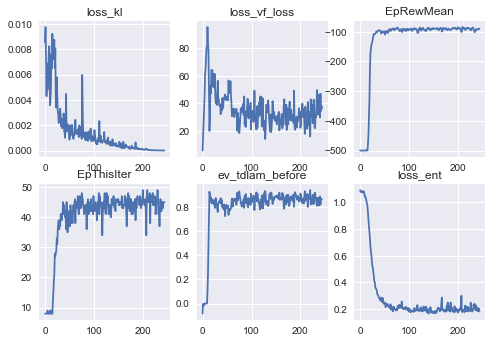

In [3]:
columns = ['loss_kl', 'loss_vf_loss', 'EpRewMean', 'EpThisIter', 'ev_tdlam_before', 'loss_ent']

nrow = 2
ncol = 3

fig, axes = plt.subplots(nrow, ncol)
i = 0
for r in range(nrow):
    for c in range(ncol):
        df[columns[i]].plot(ax=axes[r,c], title=columns[i])
        i += 1

In [18]:
LOGDIR = "bnn_acrobot"

In [5]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn")

df = pd.read_csv(LOGDIR+"/progress.csv")
df.head()

,EpThisIter,loss_pol_surr,loss_kl,loss_ent,loss_vf_loss,EpisodesSoFar,EpLenMean,TimeElapsed,EpRewMean,ev_tdlam_before,loss_pol_entpen,TimestepsSoFar
0,8,-0.004090,0.005345,1.093306,94.374830,8,500.000000,44.027443,-500.000000,-0.000174,0.0,4096
1,8,-0.002445,0.001788,1.095831,16.246672,16,500.000000,85.937326,-500.000000,0.055033,0.0,8192
2,8,-0.007889,0.009487,1.081282,24.980585,24,500.000000,126.887491,-500.000000,0.240639,0.0,12288
3,8,-0.006306,0.006660,1.056307,38.121216,32,497.000000,169.156316,-496.750000,0.284677,0.0,16384
4,10,-0.003610,0.006880,1.024103,37.536053,42,483.142857,209.258473,-482.738095,0.350252,0.0,20480


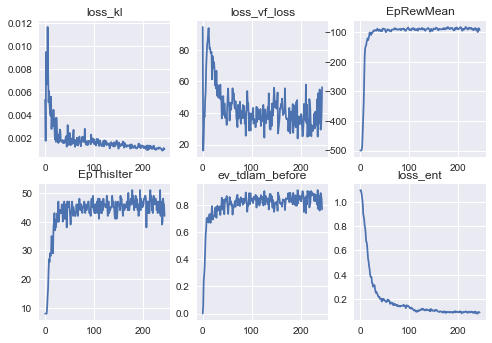

In [6]:
columns = ['loss_kl', 'loss_vf_loss', 'EpRewMean', 'EpThisIter', 'ev_tdlam_before', 'loss_ent']

nrow = 2
ncol = 3

fig, axes = plt.subplots(nrow, ncol)
i = 0
for r in range(nrow):
    for c in range(ncol):
        df[columns[i]].plot(ax=axes[r,c], title=columns[i])
        i += 1

In [11]:
LOGDIR = "bnn_acrobot"
LOGDIR1 = "acrobot"

In [12]:
# take mujoco hyperparams (but doubled timesteps_per_actorbatch to cover more steps.)
bnn = PPO1(BnnPolicy, env, timesteps_per_actorbatch=4096, clip_param=0.2, entcoeff=0.0, optim_epochs=10,
                 optim_stepsize=3e-4, optim_batchsize=64, gamma=0.99, lam=0.95, schedule='linear', verbose=2)
# take mujoco hyperparams (but doubled timesteps_per_actorbatch to cover more steps.)
dnn = PPO1(MlpPolicy, env, timesteps_per_actorbatch=4096, clip_param=0.2, entcoeff=0.0, optim_epochs=10,
                 optim_stepsize=3e-4, optim_batchsize=64, gamma=0.99, lam=0.95, schedule='linear', verbose=2)
bnn.load_parameters(os.path.join(LOGDIR, "final_model"))
dnn.load_parameters(os.path.join(LOGDIR1, "final_model"))





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [62]:
from stable_baselines.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(dnn, dnn.get_env(), n_eval_episodes=1000)
print(f"DNN - Mean reward: {mean_reward}, Std reward: {std_reward}")

mean_reward, std_reward = evaluate_policy(bnn, bnn.get_env(), n_eval_episodes=1000)
print(f"BNN - Mean reward: {mean_reward}, Std reward: {std_reward}")

DNN - Mean reward: 156.935, Std reward: 48.66798511341928
BNN - Mean reward: 189.304, Std reward: 18.416991719605022


In [67]:
from stable_baselines.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(dnn, dnn.get_env(), n_eval_episodes=1000)
print(f"DNN - Mean reward: {mean_reward}, Std reward: {std_reward}")

mean_reward, std_reward = evaluate_policy(bnn, bnn.get_env(), n_eval_episodes=1000)
print(f"BNN - Mean reward: {mean_reward}, Std reward: {std_reward}")

DNN - Mean reward: 161.503, Std reward: 47.323144348193935
BNN - Mean reward: 178.989, Std reward: 32.992982268961384


In [23]:
import base64
import IPython
import imageio

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def record_game(model, env, num_episodes=5, video_filename='video.mp4'):
    with imageio.get_writer(video_filename, fps=60) as video:
        for _ in range(num_episodes):
            obs = env.reset()
            done = False
            total_reward = 0
            video.append_data(env.render('rgb_array'))

            while not done:
                action, _steps = model.predict(obs)
                obs, reward, done, info = env.step(action)
                total_reward += reward
                video.append_data(env.render('rgb_array'))

            print("score:", total_reward)

In [27]:
record_game(bnn, env= bnn.get_env(), video_filename="bnn_acrobot.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


score: -99.0
score: -70.0
score: -80.0
score: -71.0
score: -71.0


In [28]:
record_game(dnn, env= bnn.get_env(), video_filename="dnn_acrobot.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


score: -90.0
score: -64.0
score: -84.0
score: -69.0
score: -71.0


In [29]:
env.close()

In [20]:
env.reset()

array([ 0.99984574, -0.01756392,  0.99954103, -0.03029402, -0.02566405,
        0.07983799])

In [13]:
import numpy as np

In [14]:
model = dnn


In [44]:
sampleStates1 = []
actionProbs1 = []
actionTaken1 = []

In [45]:
samples = 10
threshold = 0.05# to get a random sample of states 
obs = env.reset()
done = False
total_reward = 0
epsilon = np.random.rand()
while not done:
    action, _steps = model.predict(obs)
    epsilon = np.random.rand()
    if epsilon < threshold:
        sampleStates.append(obs)
        for i in range(samples):
        x = model.action_probability(obs)
        actionProbs.append()
        actionTaken.append(action)
    obs, reward, done, info = env.step(action)
    total_reward += reward

In [46]:
sampleStates

[array([ 0.92475341,  0.38056686,  0.68388995, -0.72958518,  0.31367297,
        -1.16466659]),
 array([ 0.38541505, -0.92274332,  0.42250234,  0.90636184, -2.29990768,
         4.54188642]),
 array([ 0.09719838, -0.99526503, -0.50891873,  0.86081457,  2.73971728,
         0.84946119]),
 array([ 0.99073933,  0.13577766,  0.2635823 ,  0.96463691,  4.68730119,
        -4.93407587])]

In [47]:
actionProbs

[array([0.9798788 , 0.00418431, 0.015937  ], dtype=float32),
 array([0.00269753, 0.00695524, 0.99034715], dtype=float32),
 array([0.6481798 , 0.28297842, 0.06884169], dtype=float32),
 array([9.9926037e-01, 6.7839486e-04, 6.1266510e-05], dtype=float32)]

In [49]:
actionTaken

[0, 2, 0, 0]

In [48]:
model.get_env()

<TimeLimit<AcrobotEnv<Acrobot-v1>>>

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/stephen/anaconda3/envs/slime-rl/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Action Probability Distribution where action taken is 0'),
 Text(0, 0.5, 'Probability')]

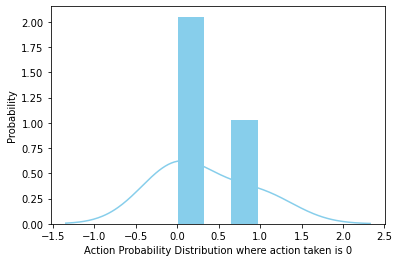

In [63]:
i = 0
ax = sns.distplot(actionProbs[i],
                 bins = env.action_space.n,
                 kde = True,
                 color = 'skyblue',
                 hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel = f'Action Probability Distribution where action taken is {actionTaken[i]}', ylabel = 'Probability')

In [55]:
actionProbs[1]

array([0.00269753, 0.00695524, 0.99034715], dtype=float32)

In [65]:
sampling = sampleStates[0]

In [69]:
something = []
for i in range(1000):
    something.append(model.predict(sampling, deterministic=False))
print(something)

[(0, None), (0, None), (0, None), (0, None), (1, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (2, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)

In [70]:
model.action_probability(sampling)

array([0.9798788 , 0.00418431, 0.015937  ], dtype=float32)

In [71]:
m2 = bnn

In [72]:
something2 = []
for i in range(1000):
    something.append(m2.predict(sampling, deterministic=False))
print(something)

[(0, None), (0, None), (0, None), (0, None), (1, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (2, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)

In [74]:
m2.action_probability(sampling)

array([0.9659492 , 0.00875428, 0.02529657], dtype=float32)